In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
import scipy
from scipy.stats import norm

seed = 10
np.random.seed(seed)

In [2]:
def fpr_at_fixed_tpr(fprs, tprs, thresholds, tpr_level: float = 0.95):
    if all(tprs < tpr_level):
        raise ValueError(f"No threshold allows for TPR at least {tpr_level}.")
    idxs = [i for i, x in enumerate(tprs) if x >= tpr_level]
    if len(idxs) > 0:
        idx = min(idxs)
    else:
        idx = 0
    return fprs[idx], tprs[idx], thresholds[idx]

def fpr_at_fixed_tpr_2(fprs, tprs, thrs, target_tpr=0.95):
        """
        Given the FPR and TPR arrays, find the FPR at a specified TPR.
        
        Args:
            fprs (ndarray): Array of false positive rates.
            tprs (ndarray): Array of true positive rates.
            thrs (ndarray): Array of thresholds.
            target_tpr (float): The target true positive rate.
            
        Returns:
            fpr_val (float): The false positive rate at the specified TPR.
            tpr_val (float): The true positive rate at the specified TPR.
            thr_val (float): The threshold at the specified TPR.
        """
        tprs
        idx = np.argmin(tprs - target_tpr)
        return fprs[idx], tprs[idx], thrs[idx]


means = [0., 1.]
std = [0.4, 0.4]
weights = [0.5, 0.5]


def gaussian_pdf(x, mean, std):
    return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)


def mixture_pdf(x, means, std, weights):
    return sum(w * gaussian_pdf(x, m, s) for w, m, s in zip(weights, means, std))

def mixture_cond_pdf(x, y, means, std, weights):
    return  (weights[y] * gaussian_pdf(x, means[y], std[y]) ) /  sum(w * gaussian_pdf(x, m, s) for w, m, s in zip(weights, means, std))

def func_proba_error(x, model):
    pred = model(x)
    return 1 - mixture_cond_pdf(x, pred, means, std, weights)

def total_proba_error(threshold, weights=weights, means=means, std=std):
    return weights[0] * (1 - norm.cdf(threshold, means[0], std[0])) + weights[1] * norm.cdf(threshold, means[1], std[1])

def total_proba_no_error(threshold, weights=weights, means=means, std=std):
    return weights[0] * norm.cdf(threshold, means[0], std[0]) + weights[1] * (1 - norm.cdf(threshold, means[1], std[1]))

from scipy.stats import norm

# Compute the density of x knowing we make an error
def density_conditionnal_error(x, weights, means, std, threshold=0.3):

    tot_proba_error = total_proba_error(threshold, weights, means, std)
    if x > threshold:
        return (weights[0] * norm.pdf(x, means[0], std[0])) / tot_proba_error
    else:
        return (weights[1] * norm.pdf(x, means[1], std[1])) / tot_proba_error
    

def density_conditionnal_no_error(x, weights, means, std, threshold=0.3):

    tot_proba_no_error = total_proba_no_error(threshold, weights, means, std)
    if x > threshold:
        return (weights[1] * norm.pdf(x, means[1], std[1])) / tot_proba_no_error
    else:
        return (weights[0] * norm.pdf(x, means[0], std[0])) / tot_proba_no_error


def classifier(x, threshold = 0.3):
    return 1 if x > threshold else 0

def bayes_classifier(x):
    p1 = gaussian_pdf(x, means[0], std[0])
    p2 = gaussian_pdf(x, means[1], std[1])
    return 1 if p2 > p1 else 0




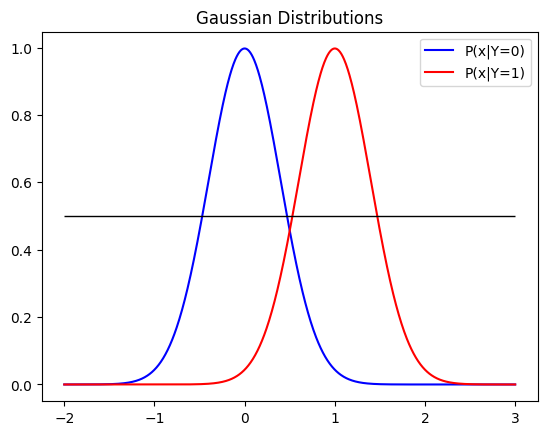

In [3]:


x = np.linspace(-2, 3, 1000)
y1 = gaussian_pdf(x, means[0], std[0])
y2 = gaussian_pdf(x, means[1], std[1])

plt.plot(x, y1 , label='P(x|Y=0)', color='blue')
plt.plot(x, y2, label='P(x|Y=1)', color='red')
# plt.plot(x, mixture_cond_pdf(x, 1, means, std, weights), label='P(Y=1|X=x)', color='green')
# plt.plot(x, mixture_cond_pdf(x, 0, means, std, weights), label='P(Y=0|X=x)', color='orange')
plt.hlines(0.5, xmin=-2, xmax=3, color='black', lw=1)
plt.title('Gaussian Distributions')
plt.legend()



In [8]:
def generate(N, weights, means, std, seed=10):

    np.random.seed(seed)
    data = np.zeros((N, 2))
    for i in range(N):
        if np.random.rand() < weights[0]:
            inputs_0 = np.random.normal(loc=means[0], scale=std[0], size=1)
            data[i,:] = [inputs_0[0], 0]
        else:
            inputs_1 = np.random.normal(loc=means[1], scale=std[1], size=1)
            data[i,:] = [inputs_1[0], 1]
    return data

def evaluate_detector(model, detector, weights, means, std, N=40000, tpr_target=0.95, seed=10):

    data = generate(N, weights, means, std, seed=seed)

    preds = np.array([model(x) for x in data[:,0]])
    error = preds != data[:,1]
    # detector_preds = np.array([detector(x, model) for x in data[:,0]])
    detector_preds = np.array([detector(x) for x in data[:,0]])
    # print("detector", detector_preds)
    # print("errors", error)
    if tpr_target is not None:
        fprs, tprs, thrs = roc_curve(error, detector_preds)
        fpr_val, tpr_val, thr_val = fpr_at_fixed_tpr(fprs, tprs, thrs, tpr_target)
        print("fpr_val", fpr_val)
        print("tpr_val", tpr_val)
        print("thr_val", thr_val)


        detector_threshold = lambda x : 1 if detector(x) > thr_val else 0
        return fpr_val, tpr_val, thr_val, detector_threshold


    
    # detector_preds = 1 if detector_preds > tpr_val else 0
    detector_error = detector_preds != error
    n_positive = np.sum(error == 1)
    n_negative = np.sum(error == 0)
    true_positives = np.sum(detector_preds & error)
    false_positives = np.sum(detector_preds & ~error)

    # print("inputs", inputs)
    # print("targets", inputs[:,1])
    # print("preds", preds)
    # print("error", error)
    # print("detector", detector_preds)
    # print(f"Classifier Error rate: {np.mean(error)}")

    print(f"Detector error rate: {np.mean(detector_error)}")
    print(f"True positives Rate: {true_positives / n_positive}")
    print(f"False positives Rate: {false_positives / n_negative}")


In [15]:
class PartitionDetector:
    def __init__(self, classifier,  weights, means, std, n_cluster = 100, alpha=0.05, method="uniform",seed=107):
        self.n_cluster = n_cluster
        self.classifier = classifier
        self.alpha = alpha
        self.seed = seed
        self.weights = weights
        self.means = means
        self.std = std
        self.method = method

    def fit(self, N=20000):
        data = generate(N, self.weights, self.means, self.std, seed=self.seed)
        inputs = data[:,0]
        classif_preds = np.array([self.classifier(x) for x in inputs])
        errors = classif_preds != data[:,1]
        clusters = np.array([self.predict_clusters(x) for x in inputs])
        # proba_error = np.array([func_proba_error(x, self.classifier) for x in inputs])
        # clusters = np.floor(proba_error * self.n_cluster).astype(int)
        # Handle edge case where an embedding equals 1
        # clusters[clusters == self.n_cluster] = self.n_cluster - 1

        self.cluster_counts, self.cluster_error_means, self.cluster_error_vars, self.cluster_intervals = [], [], [], []
        
        for i in range(self.n_cluster):
            idx = np.where(clusters == i)[0]
            count = idx.size
            self.cluster_counts.append(count)
            if count > 0:
                error_mean = np.mean(errors[idx])
                self.cluster_error_means.append(error_mean)
                error_vars = np.var(errors[idx])
                self.cluster_error_vars.append(error_vars)
                half_width = np.sqrt(np.log(2 / self.alpha) / (2 * count))
                lower_bound = max(0.0, error_mean - half_width)
                upper_bound = min(1.0, error_mean + half_width)
                self.cluster_intervals.append((lower_bound, upper_bound))
            else:
                self.cluster_error_means.append(0.0)
                self.cluster_error_vars.append(0.0)
                self.cluster_intervals.append((0, 1))

    def predict_clusters(self, x):
        if self.method == "uniform":
            
            proba_error = func_proba_error(x, self.classifier)
            clusters = int(np.floor(proba_error * self.n_cluster))
            # Handle edge case where an embedding equals 1
            if clusters == self.n_cluster:
                clusters = self.n_cluster - 1
        return clusters

    def __call__(self, x):
        proba_error = func_proba_error(x, self.classifier)
        cluster = int(np.floor(proba_error * self.n_cluster))
        # Handle edge case where an embedding equals 1
        if cluster == self.n_cluster:
            cluster = self.n_cluster - 1
        _, upper_bound = self.cluster_intervals[cluster]
        return upper_bound



In [6]:
model = lambda x: classifier(x, threshold=0.3)
def bayes_detector(x, classifier=model):
    return func_proba_error(x, classifier)

def neyman_pearson_soft_detector(x):
    ratio =  density_conditionnal_error(x, weights, means, std, threshold=0.3) / density_conditionnal_no_error(x, weights, means, std, threshold=0.3)
    return ratio



# evaluate_detector(model, neyman_pearson_detector, weights, means, std)


In [9]:
_, _ ,_, bayes_hard_detector = evaluate_detector(model, lambda x : bayes_detector(x, model), weights, means, std)

fpr_val 0.41079507795164405
tpr_val 0.9501792791092659
thr_val 0.0451318256942459


In [ ]:
for N_fit in [10000 * i for i in range(1, 11)]:
    print("N_fit", N_fit)
    partition_detector = PartitionDetector(model, weights, means, std, n_cluster=1000, alpha=0.05, seed=107)
    partition_detector.fit(N=N_fit)

    evaluate_detector(model, partition_detector, weights, means, std)

N_fit 10000
fpr_val 0.42900780957321116
tpr_val 0.9511228533685601
thr_val 0.24371940500729297
N_fit 20000
fpr_val 0.4203048903489813
tpr_val 0.9503679939611247
thr_val 0.18860809723627442
N_fit 30000
fpr_val 0.42967061467969225
tpr_val 0.9522551424797131
thr_val 0.16208358169366052
N_fit 40000
fpr_val 0.42163050056194346
tpr_val 0.9509341385167013
thr_val 0.14849825791467536
N_fit 50000
fpr_val 0.4186046511627907
tpr_val 0.951311568220419
thr_val 0.13789388166934752
N_fit 60000
fpr_val 0.42047779602893287
tpr_val 0.9501792791092659
thr_val 0.13205274425349714
N_fit 70000
fpr_val 0.424195268147892
tpr_val 0.951311568220419
thr_val 0.12402215097656821
N_fit 80000
fpr_val 0.4190945505893202
tpr_val 0.9507454236648424
thr_val 0.12201929943744362
N_fit 90000
fpr_val 0.4173943114031296
tpr_val 0.9518777127759954
thr_val 0.11736614818661545
N_fit 100000
fpr_val 0.4132157574709662
tpr_val 0.9509341385167013
thr_val 0.11370838138433673


In [132]:
x = torch.tensor([0.5, 0.1])
print(x.shape)
t = torch.tensor(0.3)
print(t.shape)
(x > 0.3).float()

# Pre-allocate an array for the results of shape (N, 2)
predictions = torch.zeros((x.shape[0], 2))

# For values greater than the threshold, set the second element to 1.
predictions[x > t, 1] = 1

# For values less than or equal to the threshold, set the first element to 1.
predictions[x <= t, 0] = 1
predictions


torch.Size([2])
torch.Size([])


tensor([[0., 1.],
        [1., 0.]])

total_proba_error(threshold) 0.8943502263331446


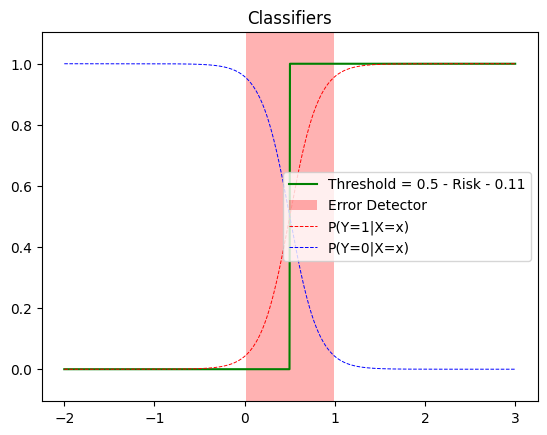

In [116]:


xs = np.linspace(-2, 3, 1000)
threshold = 0.5
print("total_proba_error(threshold)", 1 - total_proba_error(threshold))
detector_ys = np.array([bayes_hard_detector(x) for x in xs])
mask_detector = detector_ys == 1
plt.plot(x, [classifier(x, threshold) for x in xs],
          label=f'Threshold = {threshold} - Risk - {total_proba_error(threshold):.2}', color='green')
# plt.plot(x, [bayes_hard_detector(x) for x in xs],
#           label='Bayes Detector', color='orange')
plt.fill_between(xs, 0, 1, where=mask_detector, facecolor='red', alpha=0.3, label = "Error Detector",
                 transform=plt.gca().get_xaxis_transform())
# plt.plot(x, [neyman_pearson_detector(x) for x in xs],
#           label="detector", color='black')
# plt.plot(x, [bayes_classifier(x) for x in xs],
#           label='Bayes classifier', color='orange')
# plt.plot(x, [proba_error(x, classifier) for x in xs],
#           label=r'$P(E \mid X=x)$', color='purple')

# plt.plot(x, [density_conditionnal_error(x, weights, means, std, threshold) for x in xs],
#          label = r'$p(x \mid E)$', color='black')
# plt.plot(x, [density_conditionnal_no_error(x, weights, means, std, threshold) for x in xs],
#          label = r'$p(x \mid E^c)$', color='blue')
# plt.plot(x, [total_proba_no_error(threshold, weights, means, std) * density_conditionnal_no_error(x, weights, means, std, threshold) + total_proba_error(threshold, weights, means, std) * density_conditionnal_error(x, weights, means, std, threshold) for x in xs],
#          label = 'test', color='pink')
# plt.plot(x, mixture_pdf(x, means, std, weights), label='Mixture PDF', linestyle="--", color='black')

plt.plot(x, mixture_cond_pdf(x, 1, means, std, weights), label='P(Y=1|X=x)', linestyle="--", linewidth=0.7, color='red')
plt.plot(x, mixture_cond_pdf(x, 0, means, std, weights), label='P(Y=0|X=x)', linestyle="--", linewidth=0.7,color='blue')
plt.title('Classifiers')
plt.legend()

# Misclassification Detector 2D

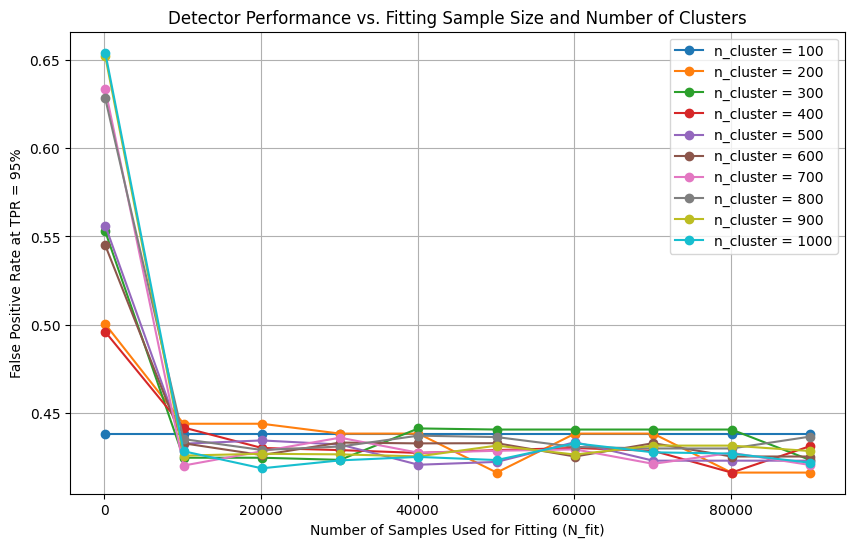

In [ ]:
N_fit_vals = range(100, 100000, 10000)

# Define the range of number of clusters to use
n_clusters_range = list(range(100, 1100, 100))
# n_clusters_range = [1000]

# Dictionary to record performance.
# For each n_cluster value, store a list of the measured FPR at TPR=95% (one per N_fit).
performance_results = {n_cluster: [] for n_cluster in n_clusters_range}

# Generate a fixed fitting dataset using the largest sample size.
max_N_fit = max(N_fit_vals)
fitting_data_full = generate(max_N_fit, weights, means, std, seed=107)

# Generate a fixed evaluation dataset (here we use N_eval = 20000).
N_eval = 20000
evaluation_data = generate(N_eval, weights, means, std, seed=10)

# -----------------------------
# Loop over N_fit and n_cluster to fit and evaluate models
# -----------------------------
for N_fit in N_fit_vals:
    # Use the first N_fit samples from the fixed fitting dataset.
    fitting_data = fitting_data_full[:N_fit]
    
    for n_cluster in n_clusters_range:
        # Instantiate a detector with the current n_cluster value.
        detector = PartitionDetector(classifier, weights, means, std, n_cluster=n_cluster, alpha=0.05, seed=107)
        
        # --- Fit using the fixed fitting dataset ---
        inputs = fitting_data[:, 0]
        classif_preds = np.array([classifier(x) for x in inputs])
        errors = classif_preds != fitting_data[:, 1]
        proba_error_vals = np.array([func_proba_error(x, classifier) for x in inputs])
        clusters = np.floor(proba_error_vals * n_cluster).astype(int)
        clusters[clusters == n_cluster] = n_cluster - 1
        
        # Compute the clustering statistics for each cluster.
        cluster_counts = []
        cluster_error_means = []
        cluster_error_vars = []
        cluster_intervals = []
        for i in range(n_cluster):
            idx = np.where(clusters == i)[0]
            count = idx.size
            cluster_counts.append(count)
            if count > 0:
                error_mean = np.mean(errors[idx])
                cluster_error_means.append(error_mean)

                half_width = np.sqrt(np.log(2 / detector.alpha) / (2 * count))
                lower_bound = max(0.0, error_mean - half_width)
                upper_bound = min(1.0, error_mean + half_width)
                cluster_intervals.append((lower_bound, upper_bound))
            else:
                cluster_error_means.append(0.0)
                cluster_error_vars.append(0.0)
                cluster_intervals.append((0, 1))
        
        # Update the detector with the computed clusters and intervals.
        detector.cluster_counts = cluster_counts
        detector.cluster_error_means = cluster_error_means
        detector.cluster_error_vars = cluster_error_vars
        detector.cluster_intervals = cluster_intervals
        
        # --- Evaluate performance on the fixed evaluation dataset ---
        eval_inputs = evaluation_data[:, 0]
        # First, get the classifier predictions and find where errors occur.
        eval_classifier_preds = np.array([classifier(x) for x in eval_inputs])
        error_flags = (eval_classifier_preds != evaluation_data[:, 1])
        
        # Get the detector outputs for each evaluation input.
        detector_outputs = np.array([detector(x) for x in eval_inputs])
        
        # Compute the ROC curve using error flags and detector outputs.
        fprs, tprs, thresholds = roc_curve(error_flags, detector_outputs)
        fpr_val, tpr_val, thr_val = fpr_at_fixed_tpr(fprs, tprs, thresholds, tpr_level=0.95)
        
        # Record the performance for this configuration.
        performance_results[n_cluster].append(fpr_val)


# -----------------------------
# Plotting the results
# -----------------------------
plt.figure(figsize=(10, 6))
for n_cluster in n_clusters_range:
    plt.plot(N_fit_vals, performance_results[n_cluster], marker='o', label=f'n_cluster = {n_cluster}')
plt.xlabel('Number of Samples Used for Fitting (N_fit)')
plt.ylabel('False Positive Rate at TPR = 95%')
plt.title('Detector Performance vs. Fitting Sample Size and Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()


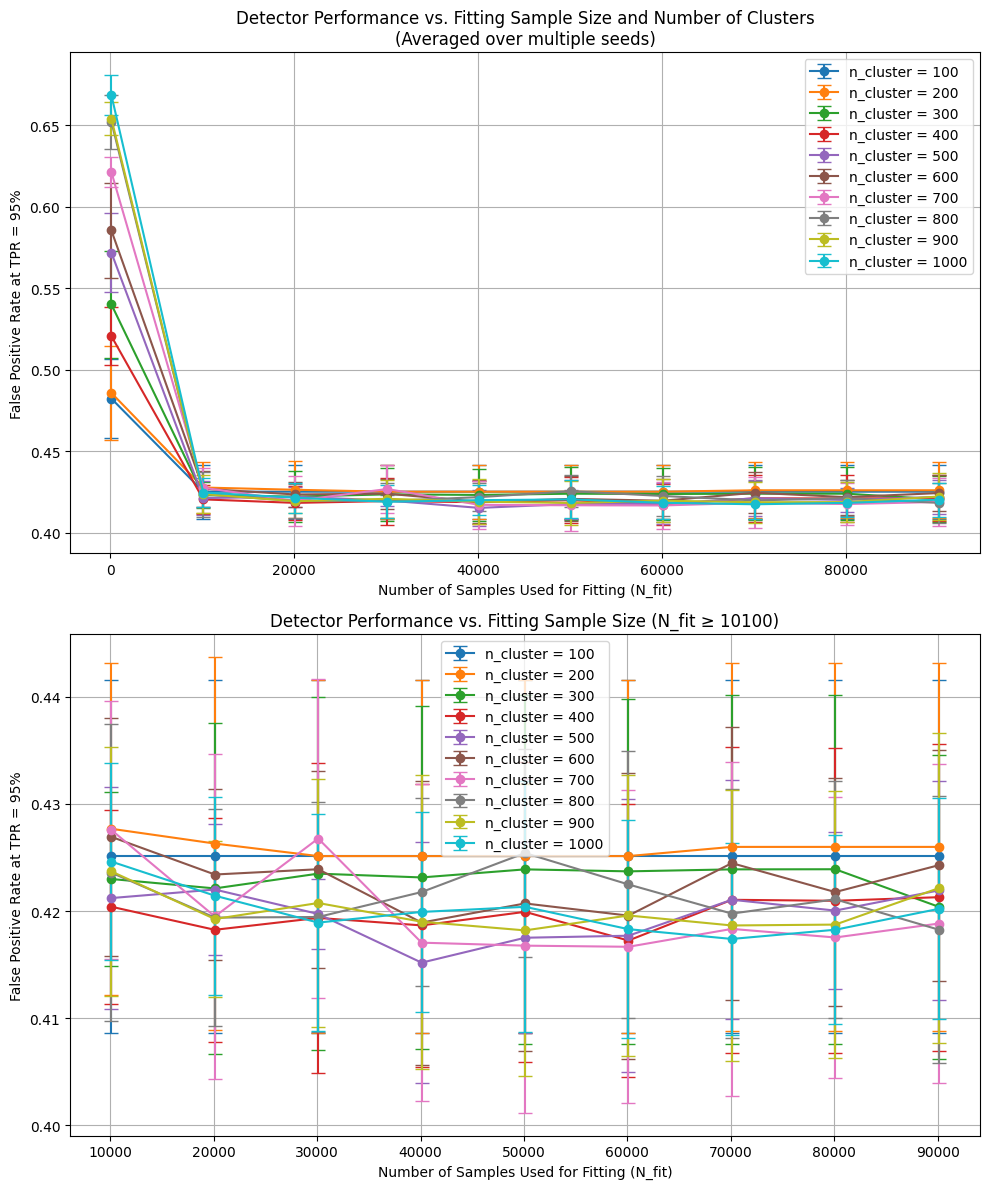

In [ ]:
# -----------------------------
# Define the different N_fit sample sizes and number of clusters to try
N_fit_vals = range(100, 100000, 10000)
n_clusters_range = list(range(100, 1100, 100))

# Define a list of seeds for repeating the experiment (you can adjust the number and values here)
seed_list = [42, 107, 2021, 7, 999]

# For each n_cluster and each N_fit, we will record FPRs across different experiment runs.
# Here we use a nested dictionary: keys are n_cluster and then N_fit
performance_results = {n_cluster: {N_fit: [] for N_fit in N_fit_vals} for n_cluster in n_clusters_range}

# Use the maximum N_fit for generating a fitting dataset
max_N_fit = max(N_fit_vals)

# Evaluation dataset size remains fixed for all experiments
N_eval = 20000

# -----------------------------
# Experiment Loop: Over Different Seeds
# -----------------------------
for seed in seed_list:
    # Generate a new fixed fitting dataset and evaluation dataset for this run.
    # (Optionally, you could use different seeds for fitting and evaluation; here we use seed and a shifted value.)
    fitting_data_full = generate(max_N_fit, weights, means, std, seed=seed)
    evaluation_data = generate(N_eval, weights, means, std, seed=seed + 1000)

    # Loop over the different fitting sample sizes
    for N_fit in N_fit_vals:
        # Use the first N_fit samples from the fitting dataset
        fitting_data = fitting_data_full[:N_fit]

        # Loop over the different n_cluster choices
        for n_cluster in n_clusters_range:
            # Instantiate the detector. Here we also pass the current seed.
            detector = PartitionDetector(classifier, weights, means, std,
                                         n_cluster=n_cluster, alpha=0.05, seed=seed)

            # --- Fit the Detector on the Current Fitting Dataset ---
            inputs = fitting_data[:, 0]
            # Get classifier predictions and compute error flags for each training sample.
            classif_preds = np.array([classifier(x) for x in inputs])
            errors = (classif_preds != fitting_data[:, 1])
            # Get the estimated error probabilities from the provided function.
            proba_error_vals = np.array([func_proba_error(x, classifier) for x in inputs])
            # Allocate each sample to a cluster by scaling to the number of clusters.
            clusters = np.floor(proba_error_vals * n_cluster).astype(int)
            clusters[clusters == n_cluster] = n_cluster - 1

            # Initialize lists to hold per-cluster statistics.
            cluster_counts = []
            cluster_error_means = []
            cluster_error_vars = []
            cluster_intervals = []

            # Compute statistics for each cluster.
            for i in range(n_cluster):
                idx = np.where(clusters == i)[0]
                count = idx.size
                cluster_counts.append(count)
                if count > 0:
                    error_mean = np.mean(errors[idx])
                    cluster_error_means.append(error_mean)
                    # Compute the half-width of the confidence interval based on count and alpha.
                    half_width = np.sqrt(np.log(2 / detector.alpha) / (2 * count))
                    lower_bound = max(0.0, error_mean - half_width)
                    upper_bound = min(1.0, error_mean + half_width)
                    cluster_intervals.append((lower_bound, upper_bound))
                    # Optionally, compute the variance if needed.
                    cluster_error_vars.append(np.var(errors[idx]))
                else:
                    cluster_error_means.append(0.0)
                    cluster_error_vars.append(0.0)
                    cluster_intervals.append((0, 1))

            # Update the detector with the computed statistics.
            detector.cluster_counts = cluster_counts
            detector.cluster_error_means = cluster_error_means
            detector.cluster_error_vars = cluster_error_vars  # or assign to detector.cluster_vars if that’s the attribute name
            detector.cluster_intervals = cluster_intervals

            # --- Evaluate Performance on the Evaluation Dataset ---
            eval_inputs = evaluation_data[:, 0]
            eval_classifier_preds = np.array([classifier(x) for x in eval_inputs])
            error_flags = (eval_classifier_preds != evaluation_data[:, 1])
            # Compute detector outputs for each evaluation sample.
            detector_outputs = np.array([detector(x) for x in eval_inputs])
            # Obtain ROC curve values based on the detector outputs.
            fprs, tprs, thresholds = roc_curve(error_flags, detector_outputs)
            fpr_val, tpr_val, thr_val = fpr_at_fixed_tpr(fprs, tprs, thresholds, tpr_level=0.95)

            # Record the performance for this (n_cluster, N_fit) configuration for the current seed.
            performance_results[n_cluster][N_fit].append(fpr_val)

# -----------------------------
# Aggregating Results and Plotting
# -----------------------------
N_fit_vals_sub = [N for N in N_fit_vals if N >= 10100]

# Create a figure with 2 subplots, one above the other.
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# -----------------------------
# Plot 1: Full Range of N_fit Values
# -----------------------------
for n_cluster in n_clusters_range:
    avg_fpr = []
    std_fpr = []
    for N_fit in N_fit_vals:
        fpr_vals = np.array(performance_results[n_cluster][N_fit])
        avg_fpr.append(np.mean(fpr_vals))
        std_fpr.append(np.std(fpr_vals))
    axs[0].errorbar(N_fit_vals, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
                    label=f'n_cluster = {n_cluster}')
    
axs[0].set_xlabel('Number of Samples Used for Fitting (N_fit)')
axs[0].set_ylabel('False Positive Rate at TPR = 95%')
axs[0].set_title('Detector Performance vs. Fitting Sample Size and Number of Clusters\n(Averaged over multiple seeds)')
axs[0].legend()
axs[0].grid(True)

# -----------------------------
# Plot 2: N_fit Values Starting at 10100
# -----------------------------
for n_cluster in n_clusters_range:
    avg_fpr = []
    std_fpr = []
    for N_fit in N_fit_vals_sub:
        fpr_vals = np.array(performance_results[n_cluster][N_fit])
        avg_fpr.append(np.mean(fpr_vals))
        std_fpr.append(np.std(fpr_vals))
    axs[1].errorbar(N_fit_vals_sub, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
                    label=f'n_cluster = {n_cluster}')
    
axs[1].set_xlabel('Number of Samples Used for Fitting (N_fit)')
axs[1].set_ylabel('False Positive Rate at TPR = 95%')
axs[1].set_title('Detector Performance vs. Fitting Sample Size (N_fit ≥ 10100)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


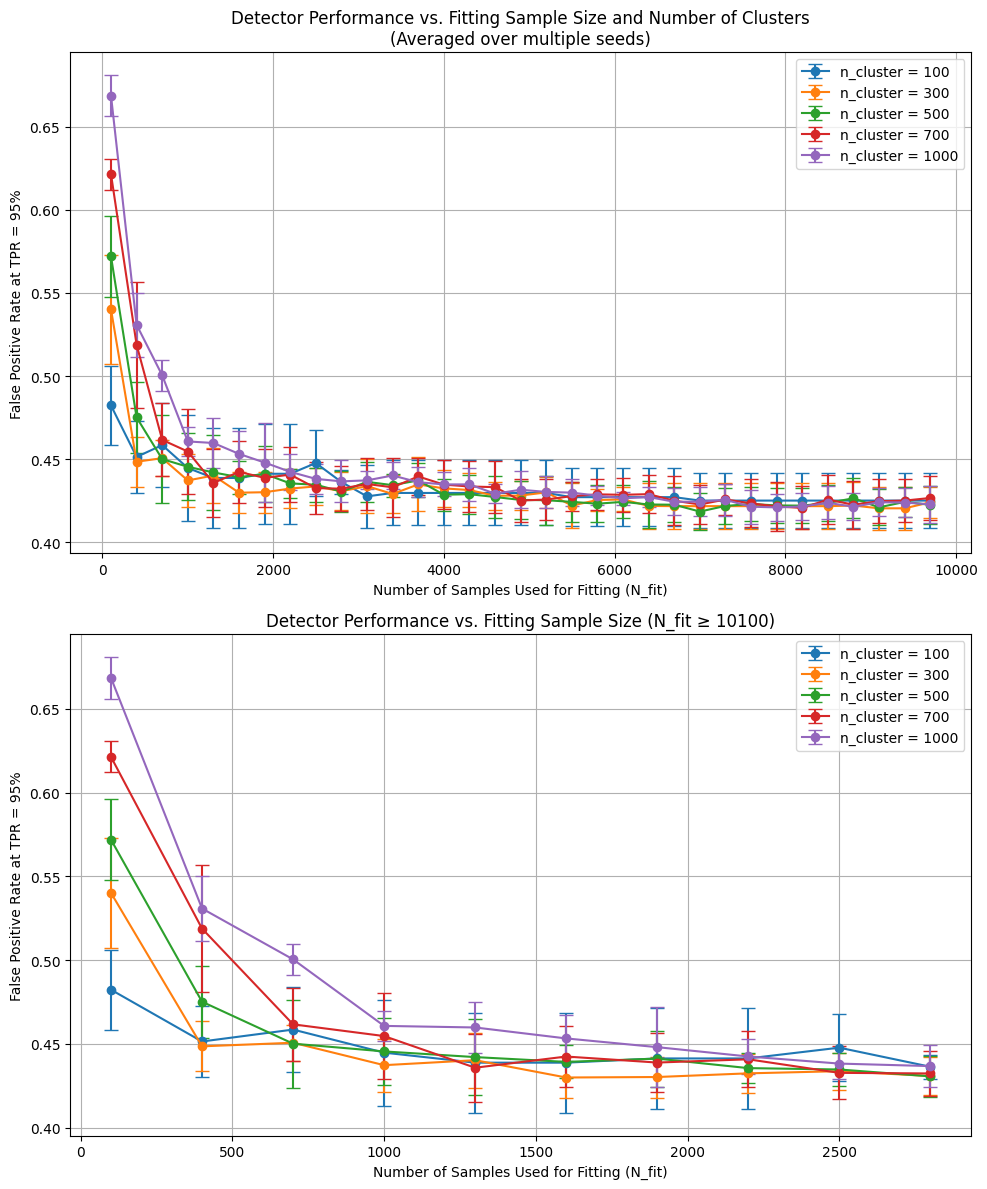

In [197]:
# # -----------------------------
# # Define the different N_fit sample sizes and number of clusters to try
# N_fit_vals = range(100, 10000, 300)
# n_clusters_range = list(range(100, 1100, 100))

# # Define a list of seeds for repeating the experiment (you can adjust the number and values here)
# seed_list = [42, 107, 2021, 7, 999]

# # For each n_cluster and each N_fit, we will record FPRs across different experiment runs.
# # Here we use a nested dictionary: keys are n_cluster and then N_fit
# performance_results = {n_cluster: {N_fit: [] for N_fit in N_fit_vals} for n_cluster in n_clusters_range}

# # Use the maximum N_fit for generating a fitting dataset
# max_N_fit = max(N_fit_vals)

# # Evaluation dataset size remains fixed for all experiments
# N_eval = 20000

# # -----------------------------
# # Experiment Loop: Over Different Seeds
# # -----------------------------
# for seed in seed_list:
#     # Generate a new fixed fitting dataset and evaluation dataset for this run.
#     # (Optionally, you could use different seeds for fitting and evaluation; here we use seed and a shifted value.)
#     fitting_data_full = generate(max_N_fit, weights, means, std, seed=seed)
#     evaluation_data = generate(N_eval, weights, means, std, seed=seed + 1000)

#     # Loop over the different fitting sample sizes
#     for N_fit in N_fit_vals:
#         # Use the first N_fit samples from the fitting dataset
#         fitting_data = fitting_data_full[:N_fit]

#         # Loop over the different n_cluster choices
#         for n_cluster in n_clusters_range:
#             # Instantiate the detector. Here we also pass the current seed.
#             detector = PartitionDetector(classifier, weights, means, std,
#                                          n_cluster=n_cluster, alpha=0.05, seed=seed)

#             # --- Fit the Detector on the Current Fitting Dataset ---
#             inputs = fitting_data[:, 0]
#             # Get classifier predictions and compute error flags for each training sample.
#             classif_preds = np.array([classifier(x) for x in inputs])
#             errors = (classif_preds != fitting_data[:, 1])
#             # Get the estimated error probabilities from the provided function.
#             proba_error_vals = np.array([func_proba_error(x, classifier) for x in inputs])
#             # Allocate each sample to a cluster by scaling to the number of clusters.
#             clusters = np.floor(proba_error_vals * n_cluster).astype(int)
#             clusters[clusters == n_cluster] = n_cluster - 1

#             # Initialize lists to hold per-cluster statistics.
#             cluster_counts = []
#             cluster_error_means = []
#             cluster_error_vars = []
#             cluster_intervals = []

#             # Compute statistics for each cluster.
#             for i in range(n_cluster):
#                 idx = np.where(clusters == i)[0]
#                 count = idx.size
#                 cluster_counts.append(count)
#                 if count > 0:
#                     error_mean = np.mean(errors[idx])
#                     cluster_error_means.append(error_mean)
#                     # Compute the half-width of the confidence interval based on count and alpha.
#                     half_width = np.sqrt(np.log(2 / detector.alpha) / (2 * count))
#                     lower_bound = max(0.0, error_mean - half_width)
#                     upper_bound = min(1.0, error_mean + half_width)
#                     cluster_intervals.append((lower_bound, upper_bound))
#                     # Optionally, compute the variance if needed.
#                     cluster_error_vars.append(np.var(errors[idx]))
#                 else:
#                     cluster_error_means.append(0.0)
#                     cluster_error_vars.append(0.0)
#                     cluster_intervals.append((0, 1))

#             # Update the detector with the computed statistics.
#             detector.cluster_counts = cluster_counts
#             detector.cluster_error_means = cluster_error_means
#             detector.cluster_error_vars = cluster_error_vars  # or assign to detector.cluster_vars if that’s the attribute name
#             detector.cluster_intervals = cluster_intervals

#             # --- Evaluate Performance on the Evaluation Dataset ---
#             eval_inputs = evaluation_data[:, 0]
#             eval_classifier_preds = np.array([classifier(x) for x in eval_inputs])
#             error_flags = (eval_classifier_preds != evaluation_data[:, 1])
#             # Compute detector outputs for each evaluation sample.
#             detector_outputs = np.array([detector(x) for x in eval_inputs])
#             # Obtain ROC curve values based on the detector outputs.
#             fprs, tprs, thresholds = roc_curve(error_flags, detector_outputs)
#             fpr_val, tpr_val, thr_val = fpr_at_fixed_tpr(fprs, tprs, thresholds, tpr_level=0.95)

#             # Record the performance for this (n_cluster, N_fit) configuration for the current seed.
#             performance_results[n_cluster][N_fit].append(fpr_val)

# # -----------------------------
# Aggregating Results and Plotting
# -----------------------------
N_fit_vals_sub = [N for N in N_fit_vals if N <= 3000]
n_clusters_range = [100, 300, 500, 700, 1000]
# Create a figure with 2 subplots, one above the other.
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# -----------------------------
# Plot 1: Full Range of N_fit Values
# -----------------------------
for n_cluster in n_clusters_range:
    avg_fpr = []
    std_fpr = []
    for N_fit in N_fit_vals:
        fpr_vals = np.array(performance_results[n_cluster][N_fit])
        avg_fpr.append(np.mean(fpr_vals))
        std_fpr.append(np.std(fpr_vals))
    axs[0].errorbar(N_fit_vals, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
                    label=f'n_cluster = {n_cluster}')
    
axs[0].set_xlabel('Number of Samples Used for Fitting (N_fit)')
axs[0].set_ylabel('False Positive Rate at TPR = 95%')
axs[0].set_title('Detector Performance vs. Fitting Sample Size and Number of Clusters\n(Averaged over multiple seeds)')
axs[0].legend()
axs[0].grid(True)

# -----------------------------
# Plot 2: N_fit Values Starting at 10100
# -----------------------------
for n_cluster in n_clusters_range:
    avg_fpr = []
    std_fpr = []
    for N_fit in N_fit_vals_sub:
        fpr_vals = np.array(performance_results[n_cluster][N_fit])
        avg_fpr.append(np.mean(fpr_vals))
        std_fpr.append(np.std(fpr_vals))
    axs[1].errorbar(N_fit_vals_sub, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
                    label=f'n_cluster = {n_cluster}')
    
axs[1].set_xlabel('Number of Samples Used for Fitting (N_fit)')
axs[1].set_ylabel('False Positive Rate at TPR = 95%')
axs[1].set_title('Detector Performance vs. Fitting Sample Size (N_fit ≥ 10100)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


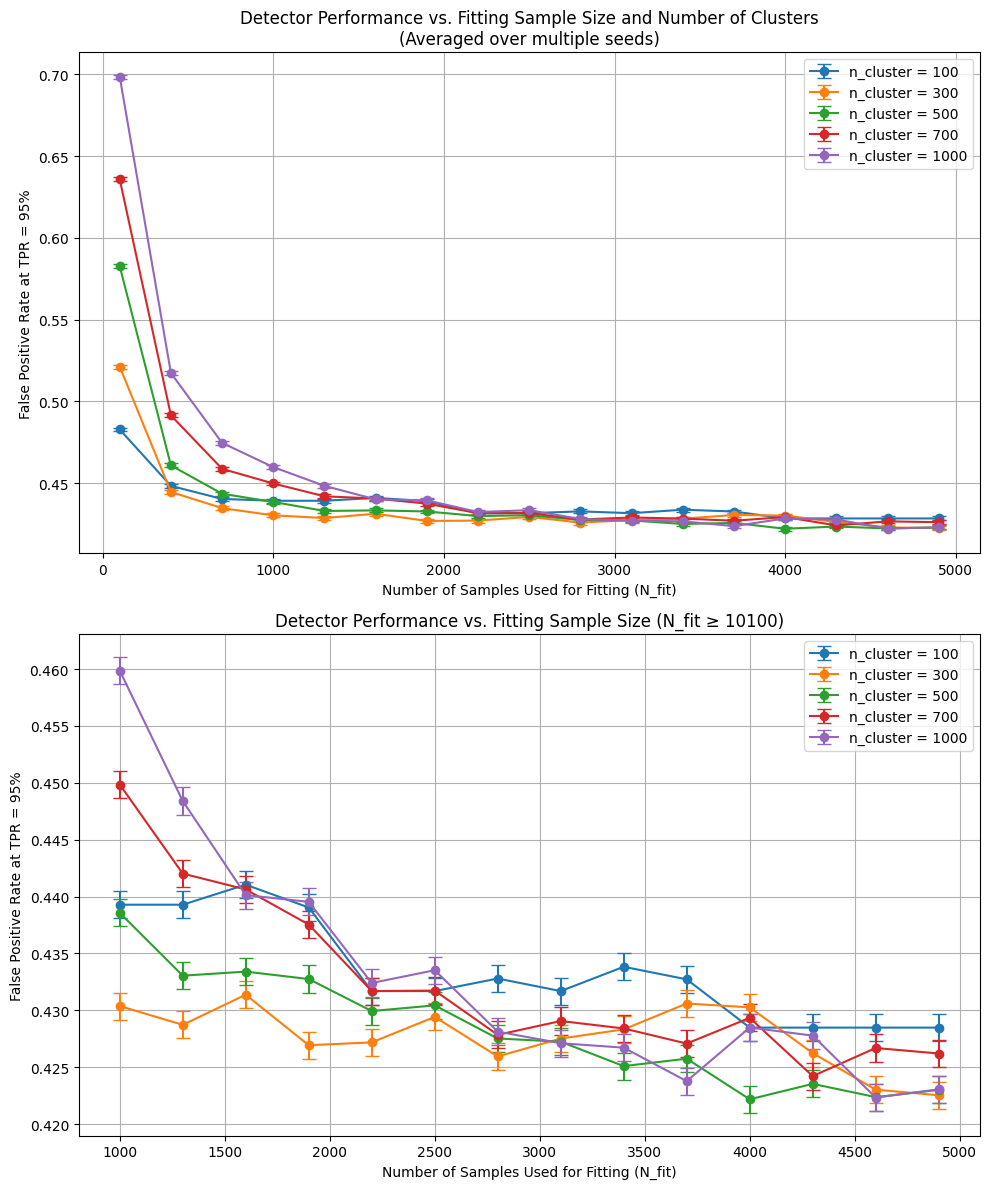

In [ ]:
# -----------------------------
# Define the different N_fit sample sizes and number of clusters to try
N_fit_vals = range(100, 5000, 300)
n_clusters_range = list(range(100, 1100, 100))

# Define a list of seeds for repeating the experiment (you can adjust the number and values here)
seed_list = np.arange(30)
n_seed = len(seed_list)

# For each n_cluster and each N_fit, we will record FPRs across different experiment runs.
# Here we use a nested dictionary: keys are n_cluster and then N_fit
performance_results = {n_cluster: {N_fit: [] for N_fit in N_fit_vals} for n_cluster in n_clusters_range}
# variance results
var_results = {n_cluster: {N_fit: [] for N_fit in N_fit_vals} for n_cluster in n_clusters_range}

# Use the maximum N_fit for generating a fitting dataset
max_N_fit = max(N_fit_vals)

# Evaluation dataset size remains fixed for all experiments
N_eval = 20000

# -----------------------------
# Experiment Loop: Over Different Seeds
# -----------------------------
for seed in seed_list:
    # Generate a new fixed fitting dataset and evaluation dataset for this run.
    # (Optionally, you could use different seeds for fitting and evaluation; here we use seed and a shifted value.)
    fitting_data_full = generate(max_N_fit, weights, means, std, seed=seed)
    evaluation_data = generate(N_eval, weights, means, std, seed=seed + 1000)

    # Loop over the different fitting sample sizes
    for N_fit in N_fit_vals:
        # Use the first N_fit samples from the fitting dataset
        fitting_data = fitting_data_full[:N_fit]

        # Loop over the different n_cluster choices
        for n_cluster in n_clusters_range:
            # Instantiate the detector. Here we also pass the current seed.
            detector = PartitionDetector(classifier, weights, means, std,
                                         n_cluster=n_cluster, alpha=0.05, seed=seed)

            # --- Fit the Detector on the Current Fitting Dataset ---
            inputs = fitting_data[:, 0]
            # Get classifier predictions and compute error flags for each training sample.
            classif_preds = np.array([classifier(x) for x in inputs])
            errors = (classif_preds != fitting_data[:, 1])
            # Get the estimated error probabilities from the provided function.
            proba_error_vals = np.array([func_proba_error(x, classifier) for x in inputs])
            # Allocate each sample to a cluster by scaling to the number of clusters.
            clusters = np.floor(proba_error_vals * n_cluster).astype(int)
            clusters[clusters == n_cluster] = n_cluster - 1

            # Initialize lists to hold per-cluster statistics.
            cluster_counts = []
            cluster_error_means = []
            cluster_error_vars = []
            cluster_intervals = []

            # Compute statistics for each cluster.
            for i in range(n_cluster):
                idx = np.where(clusters == i)[0]
                count = idx.size
                cluster_counts.append(count)
                if count > 0:
                    error_mean = np.mean(errors[idx])
                    cluster_error_means.append(error_mean)
                    # Compute the half-width of the confidence interval based on count and alpha.
                    half_width = np.sqrt(np.log(2 / detector.alpha) / (2 * count))
                    lower_bound = max(0.0, error_mean - half_width)
                    upper_bound = min(1.0, error_mean + half_width)
                    cluster_intervals.append((lower_bound, upper_bound))
                    # Optionally, compute the variance if needed.
                    cluster_error_vars.append(np.var(errors[idx]))
                else:
                    cluster_error_means.append(0.0)
                    cluster_error_vars.append(0.0)
                    cluster_intervals.append((0, 1))

            # Update the detector with the computed statistics.
            detector.cluster_counts = cluster_counts
            detector.cluster_error_means = cluster_error_means
            detector.cluster_error_vars = cluster_error_vars  # or assign to detector.cluster_vars if that’s the attribute name
            detector.cluster_intervals = cluster_intervals

            # --- Evaluate Performance on the Evaluation Dataset ---
            eval_inputs = evaluation_data[:, 0]
            eval_classifier_preds = np.array([classifier(x) for x in eval_inputs])
            error_flags = (eval_classifier_preds != evaluation_data[:, 1])
            # Compute detector outputs for each evaluation sample.
            detector_outputs = np.array([detector(x) for x in eval_inputs])
            # Obtain ROC curve values based on the detector outputs.
            fprs, tprs, thresholds = roc_curve(error_flags, detector_outputs)
            fpr_val, tpr_val, thr_val = fpr_at_fixed_tpr(fprs, tprs, thresholds, tpr_level=0.95)
            n_negatif = np.sum(error_flags == 0)
            var_fpr = fpr_val * (1 - fpr_val) / n_negatif

            # Record the performance for this (n_cluster, N_fit) configuration for the current seed.
            performance_results[n_cluster][N_fit].append(fpr_val)
            var_results[n_cluster][N_fit].append(var_fpr)

# # -----------------------------
# Aggregating Results and Plotting
# -----------------------------
N_fit_vals_sub = [N for N in N_fit_vals if N >= 1000]
n_clusters_range = [100, 300, 500, 700, 1000]
# Create a figure with 2 subplots, one above the other.
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# -----------------------------
# Plot 1: Full Range of N_fit Values
# -----------------------------
for n_cluster in n_clusters_range:
    avg_fpr = []
    std_fpr = []
    for N_fit in N_fit_vals:
        fpr_vals = np.array(performance_results[n_cluster][N_fit])
        avg_fpr.append(np.mean(fpr_vals))
        std_fpr.append(np.sqrt(np.sum(var_results[n_cluster][N_fit]) / (n_seed ** 2)))
    axs[0].errorbar(N_fit_vals, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
                    label=f'n_cluster = {n_cluster}')
    
axs[0].set_xlabel('Number of Samples Used for Fitting (N_fit)')
axs[0].set_ylabel('False Positive Rate at TPR = 95%')
axs[0].set_title('Detector Performance vs. Fitting Sample Size and Number of Clusters\n(Averaged over multiple seeds)')
axs[0].legend()
axs[0].grid(True)

# -----------------------------
# Plot 2: N_fit Values Starting at 10100
# -----------------------------
for n_cluster in n_clusters_range:
    avg_fpr = []
    std_fpr = []
    for N_fit in N_fit_vals_sub:
        fpr_vals = np.array(performance_results[n_cluster][N_fit])
        avg_fpr.append(np.mean(fpr_vals))
        std_fpr.append(np.sqrt(np.sum(var_results[n_cluster][N_fit]) / (n_seed ** 2)))
    axs[1].errorbar(N_fit_vals_sub, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
                    label=f'n_cluster = {n_cluster}')
    
axs[1].set_xlabel('Number of Samples Used for Fitting (N_fit)')
axs[1].set_ylabel('False Positive Rate at TPR = 95%')
axs[1].set_title('Detector Performance vs. Fitting Sample Size (N_fit ≥ 10100)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# -----------------------------
# Define the different N_fit sample sizes and number of clusters to try
N_fit_vals = range(10, 500000, 10000)
n_clusters_range = list(range(100, 1100, 100))

# Define a list of seeds for repeating the experiment (you can adjust the number and values here)
seed_list = np.arange(20)
n_seed = len(seed_list)

# For each n_cluster and each N_fit, we will record FPRs across different experiment runs.
# Here we use a nested dictionary: keys are n_cluster and then N_fit
performance_results = {n_cluster: {N_fit: [] for N_fit in N_fit_vals} for n_cluster in n_clusters_range}
# variance results
var_results = {n_cluster: {N_fit: [] for N_fit in N_fit_vals} for n_cluster in n_clusters_range}

# Use the maximum N_fit for generating a fitting dataset
max_N_fit = max(N_fit_vals)

# Evaluation dataset size remains fixed for all experiments
N_eval = 50000

# -----------------------------
# Experiment Loop: Over Different Seeds
# -----------------------------
for seed in seed_list:
    # Generate a new fixed fitting dataset and evaluation dataset for this run.
    # (Optionally, you could use different seeds for fitting and evaluation; here we use seed and a shifted value.)
    fitting_data_full = generate(max_N_fit, weights, means, std, seed=seed)
    evaluation_data = generate(N_eval, weights, means, std, seed=1)

    # Loop over the different fitting sample sizes
    for N_fit in N_fit_vals:
        # Use the first N_fit samples from the fitting dataset
        fitting_data = fitting_data_full[:N_fit]

        # Loop over the different n_cluster choices
        for n_cluster in n_clusters_range:
            # Instantiate the detector. Here we also pass the current seed.
            detector = PartitionDetector(classifier, weights, means, std,
                                         n_cluster=n_cluster, alpha=0.05, seed=seed)

            # --- Fit the Detector on the Current Fitting Dataset ---
            inputs = fitting_data[:, 0]
            # Get classifier predictions and compute error flags for each training sample.
            classif_preds = np.array([classifier(x) for x in inputs])
            errors = (classif_preds != fitting_data[:, 1])
            # Get the estimated error probabilities from the provided function.
            proba_error_vals = np.array([func_proba_error(x, classifier) for x in inputs])
            # Allocate each sample to a cluster by scaling to the number of clusters.
            clusters = np.floor(proba_error_vals * n_cluster).astype(int)
            clusters[clusters == n_cluster] = n_cluster - 1

            # Initialize lists to hold per-cluster statistics.
            cluster_counts = []
            cluster_error_means = []
            cluster_error_vars = []
            cluster_intervals = []

            # Compute statistics for each cluster.
            for i in range(n_cluster):
                idx = np.where(clusters == i)[0]
                count = idx.size
                cluster_counts.append(count)
                if count > 0:
                    error_mean = np.mean(errors[idx])
                    cluster_error_means.append(error_mean)
                    # Compute the half-width of the confidence interval based on count and alpha.
                    half_width = np.sqrt(np.log(2 / detector.alpha) / (2 * count))
                    lower_bound = max(0.0, error_mean - half_width)
                    upper_bound = min(1.0, error_mean + half_width)
                    cluster_intervals.append((lower_bound, upper_bound))
                    # Optionally, compute the variance if needed.
                    cluster_error_vars.append(np.var(errors[idx]))
                else:
                    cluster_error_means.append(0.0)
                    cluster_error_vars.append(0.0)
                    cluster_intervals.append((0, 1))

            # Update the detector with the computed statistics.
            detector.cluster_counts = cluster_counts
            detector.cluster_error_means = cluster_error_means
            detector.cluster_error_vars = cluster_error_vars  # or assign to detector.cluster_vars if that’s the attribute name
            detector.cluster_intervals = cluster_intervals

            # --- Evaluate Performance on the Evaluation Dataset ---
            eval_inputs = evaluation_data[:, 0]
            eval_classifier_preds = np.array([classifier(x) for x in eval_inputs])
            error_flags = (eval_classifier_preds != evaluation_data[:, 1])
            # Compute detector outputs for each evaluation sample.
            detector_outputs = np.array([detector(x) for x in eval_inputs])
            # Obtain ROC curve values based on the detector outputs.
            fprs, tprs, thresholds = roc_curve(error_flags, detector_outputs)
            fpr_val, tpr_val, thr_val = fpr_at_fixed_tpr(fprs, tprs, thresholds, tpr_level=0.95)
            n_negatif = np.sum(error_flags == 0)
            var_fpr = fpr_val * (1 - fpr_val) / n_negatif

            # Record the performance for this (n_cluster, N_fit) configuration for the current seed.
            performance_results[n_cluster][N_fit].append(fpr_val)
            var_results[n_cluster][N_fit].append(var_fpr)

# # -----------------------------
# Aggregating Results and Plotting
# -----------------------------
N_fit_vals_sub = [N for N in N_fit_vals if N >= 1000]
n_clusters_range = [100, 1000]
# Create a figure with 2 subplots, one above the other.
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# -----------------------------
# Plot 1: Full Range of N_fit Values
# -----------------------------
for n_cluster in n_clusters_range:
    avg_fpr = []
    std_fpr = []
    for N_fit in N_fit_vals:
        fpr_vals = np.array(performance_results[n_cluster][N_fit])
        avg_fpr.append(np.mean(fpr_vals))
        std_fpr.append(np.std(fpr_vals))
    axs[0].errorbar(N_fit_vals, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
                    label=f'n_cluster = {n_cluster}')
    
axs[0].set_xlabel('Number of Samples Used for Fitting (N_fit)')
axs[0].set_ylabel('False Positive Rate at TPR = 95%')
axs[0].set_title('Detector Performance vs. Fitting Sample Size and Number of Clusters\n(Averaged over multiple seeds)')
axs[0].legend()
axs[0].grid(True)

# -----------------------------
# Plot 2: N_fit Values Starting at 10100
# -----------------------------
for n_cluster in n_clusters_range:
    avg_fpr = []
    std_fpr = []
    for N_fit in N_fit_vals_sub:
        fpr_vals = np.array(performance_results[n_cluster][N_fit])
        avg_fpr.append(np.mean(fpr_vals))
        std_fpr.append(np.std(fpr_vals))
    axs[1].errorbar(N_fit_vals_sub, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
                    label=f'n_cluster = {n_cluster}')
    
axs[1].set_xlabel('Number of Samples Used for Fitting (N_fit)')
axs[1].set_ylabel('False Positive Rate at TPR = 95%')
axs[1].set_title('Detector Performance vs. Fitting Sample Size (N_fit ≥ 10100)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


[10010, 20010, 30010, 40010, 50010, 60010, 70010, 80010, 90010, 100010, 110010, 120010, 130010, 140010, 150010, 160010, 170010, 180010, 190010, 200010, 210010, 220010, 230010, 240010, 250010, 260010, 270010, 280010, 290010, 300010, 310010, 320010, 330010, 340010, 350010, 360010, 370010, 380010, 390010]
39
39
39
39
39


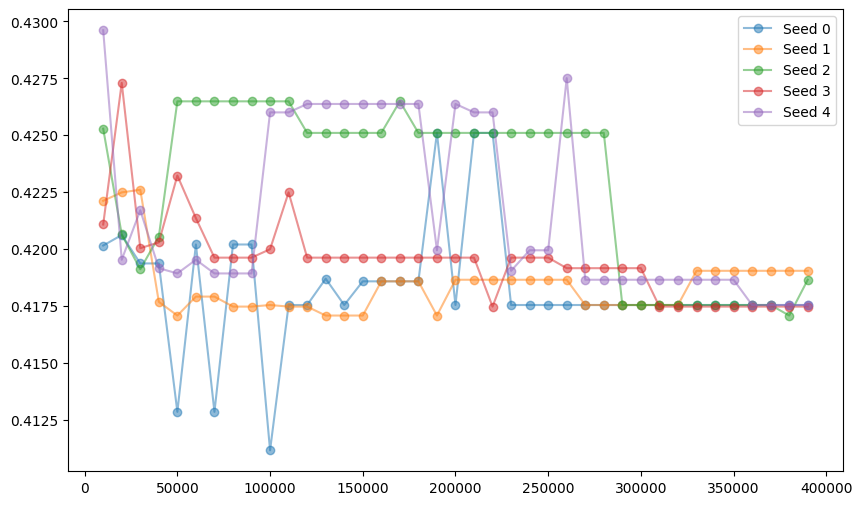

In [164]:
# # -----------------------------
# # Define the different N_fit sample sizes and number of clusters to try
# N_fit_vals = range(10, 500000, 10000)
# n_clusters_range = list(range(100, 1100, 100))

# # Define a list of seeds for repeating the experiment (you can adjust the number and values here)
# seed_list = np.arange(20)
# n_seed = len(seed_list)

# # For each n_cluster and each N_fit, we will record FPRs across different experiment runs.
# # Here we use a nested dictionary: keys are n_cluster and then N_fit
# performance_results = {n_cluster: {N_fit: [] for N_fit in N_fit_vals} for n_cluster in n_clusters_range}
# # variance results
# var_results = {n_cluster: {N_fit: [] for N_fit in N_fit_vals} for n_cluster in n_clusters_range}

# # Use the maximum N_fit for generating a fitting dataset
# max_N_fit = max(N_fit_vals)

# # Evaluation dataset size remains fixed for all experiments
# N_eval = 50000

# # -----------------------------
# # Experiment Loop: Over Different Seeds
# # -----------------------------
# for seed in seed_list:
#     # Generate a new fixed fitting dataset and evaluation dataset for this run.
#     # (Optionally, you could use different seeds for fitting and evaluation; here we use seed and a shifted value.)
#     fitting_data_full = generate(max_N_fit, weights, means, std, seed=seed)
#     evaluation_data = generate(N_eval, weights, means, std, seed=1)

#     # Loop over the different fitting sample sizes
#     for N_fit in N_fit_vals:
#         # Use the first N_fit samples from the fitting dataset
#         fitting_data = fitting_data_full[:N_fit]

#         # Loop over the different n_cluster choices
#         for n_cluster in n_clusters_range:
#             # Instantiate the detector. Here we also pass the current seed.
#             detector = PartitionDetector(classifier, weights, means, std,
#                                          n_cluster=n_cluster, alpha=0.05, seed=seed)

#             # --- Fit the Detector on the Current Fitting Dataset ---
#             inputs = fitting_data[:, 0]
#             # Get classifier predictions and compute error flags for each training sample.
#             classif_preds = np.array([classifier(x) for x in inputs])
#             errors = (classif_preds != fitting_data[:, 1])
#             # Get the estimated error probabilities from the provided function.
#             proba_error_vals = np.array([func_proba_error(x, classifier) for x in inputs])
#             # Allocate each sample to a cluster by scaling to the number of clusters.
#             clusters = np.floor(proba_error_vals * n_cluster).astype(int)
#             clusters[clusters == n_cluster] = n_cluster - 1

#             # Initialize lists to hold per-cluster statistics.
#             cluster_counts = []
#             cluster_error_means = []
#             cluster_error_vars = []
#             cluster_intervals = []

#             # Compute statistics for each cluster.
#             for i in range(n_cluster):
#                 idx = np.where(clusters == i)[0]
#                 count = idx.size
#                 cluster_counts.append(count)
#                 if count > 0:
#                     error_mean = np.mean(errors[idx])
#                     cluster_error_means.append(error_mean)
#                     # Compute the half-width of the confidence interval based on count and alpha.
#                     half_width = np.sqrt(np.log(2 / detector.alpha) / (2 * count))
#                     lower_bound = max(0.0, error_mean - half_width)
#                     upper_bound = min(1.0, error_mean + half_width)
#                     cluster_intervals.append((lower_bound, upper_bound))
#                     # Optionally, compute the variance if needed.
#                     cluster_error_vars.append(np.var(errors[idx]))
#                 else:
#                     cluster_error_means.append(0.0)
#                     cluster_error_vars.append(0.0)
#                     cluster_intervals.append((0, 1))

#             # Update the detector with the computed statistics.
#             detector.cluster_counts = cluster_counts
#             detector.cluster_error_means = cluster_error_means
#             detector.cluster_error_vars = cluster_error_vars  # or assign to detector.cluster_vars if that’s the attribute name
#             detector.cluster_intervals = cluster_intervals

#             # --- Evaluate Performance on the Evaluation Dataset ---
#             eval_inputs = evaluation_data[:, 0]
#             eval_classifier_preds = np.array([classifier(x) for x in eval_inputs])
#             error_flags = (eval_classifier_preds != evaluation_data[:, 1])
#             # Compute detector outputs for each evaluation sample.
#             detector_outputs = np.array([detector(x) for x in eval_inputs])
#             # Obtain ROC curve values based on the detector outputs.
#             fprs, tprs, thresholds = roc_curve(error_flags, detector_outputs)
#             fpr_val, tpr_val, thr_val = fpr_at_fixed_tpr(fprs, tprs, thresholds, tpr_level=0.95)
#             n_negatif = np.sum(error_flags == 0)
#             var_fpr = fpr_val * (1 - fpr_val) / n_negatif

#             # Record the performance for this (n_cluster, N_fit) configuration for the current seed.
#             performance_results[n_cluster][N_fit].append(fpr_val)
#             var_results[n_cluster][N_fit].append(var_fpr)

# # -----------------------------
# Aggregating Results and Plotting
# -----------------------------
# N_fit_vals_sub = [N for N in N_fit_vals if N >= 1000]
# n_clusters_range = [100, 1000]
# # Create a figure with 2 subplots, one above the other.
# fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# # -----------------------------
# # Plot 1: Full Range of N_fit Values
# # -----------------------------
# for n_cluster in n_clusters_range:
#     avg_fpr = []
#     std_fpr = []
#     for N_fit in N_fit_vals:
#         fpr_vals = np.array(performance_results[n_cluster][N_fit])
#         avg_fpr.append(np.mean(fpr_vals))
#         std_fpr.append(np.std(fpr_vals))
#     axs[0].errorbar(N_fit_vals, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
#                     label=f'n_cluster = {n_cluster}')
    
# axs[0].set_xlabel('Number of Samples Used for Fitting (N_fit)')
# axs[0].set_ylabel('False Positive Rate at TPR = 95%')
# axs[0].set_title('Detector Performance vs. Fitting Sample Size and Number of Clusters\n(Averaged over multiple seeds)')
# axs[0].legend()
# axs[0].grid(True)

# # -----------------------------
# # Plot 2: N_fit Values Starting at 10100
# # -----------------------------
# for n_cluster in n_clusters_range:
#     avg_fpr = []
#     std_fpr = []
#     for N_fit in N_fit_vals_sub:
#         fpr_vals = np.array(performance_results[n_cluster][N_fit])
#         avg_fpr.append(np.mean(fpr_vals))
#         std_fpr.append(np.std(fpr_vals))
#     axs[1].errorbar(N_fit_vals_sub, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
#                     label=f'n_cluster = {n_cluster}')
    
# axs[1].set_xlabel('Number of Samples Used for Fitting (N_fit)')
# axs[1].set_ylabel('False Positive Rate at TPR = 95%')
# axs[1].set_title('Detector Performance vs. Fitting Sample Size (N_fit ≥ 10100)')
# axs[1].legend()
# axs[1].grid(True)

# plt.tight_layout()
# plt.show()


plt.figure(figsize=(10, 6))
n_cluster = 600
fpr_per_seed = {seed: [] for seed in seed_list}
N_fit_new = []
for N_fit in N_fit_vals_sub:
    result = performance_results[n_cluster][N_fit]
    if len(result) <5:
        continue
    N_fit_new.append(N_fit)
    for seed, fpr in enumerate(result):
        fpr_per_seed[seed].append(fpr)
# print(fpr_per_seed[0])
print(N_fit_new)
for seed in range(5):
    print(len(fpr_per_seed[seed]))
    plt.plot(N_fit_new, fpr_per_seed[seed], alpha=0.5, marker='o', label=f'Seed {seed}')

plt.legend()

In [180]:
clusters_t = torch.tensor([[0],[1],[0],[1],[1]])

ups = torch.tensor([0.1,0.2,0.3, 0.4, 0.5])
clusters = torch.tensor([[0],[1],[0],[1],[1]])
ups[clusters].shape

torch.Size([5, 1])

In [60]:
performance_results

{100: {10: [np.float64(0.5622126204394741),
   np.float64(0.6672289100949652),
   np.float64(0.6373298828531159),
   np.float64(0.6797754107072714),
   np.float64(0.5622126204394741)],
  10010: [np.float64(0.4319878000878024),
   np.float64(0.4319878000878024),
   np.float64(0.4319878000878024),
   np.float64(0.4319878000878024),
   np.float64(0.4319878000878024)],
  20010: [np.float64(0.4319878000878024),
   np.float64(0.4319878000878024),
   np.float64(0.4319878000878024),
   np.float64(0.4319878000878024),
   np.float64(0.4319878000878024)],
  30010: [np.float64(0.4319878000878024),
   np.float64(0.4319878000878024),
   np.float64(0.4319878000878024),
   np.float64(0.4319878000878024),
   np.float64(0.4319878000878024)],
  40010: [np.float64(0.4319878000878024),
   np.float64(0.4319878000878024),
   np.float64(0.4319878000878024),
   np.float64(0.4319878000878024),
   np.float64(0.4319878000878024)],
  50010: [np.float64(0.4319878000878024),
   np.float64(0.4319878000878024),
   np.

N_fit 100
seed 0
fpr_val 0.4846785383903793
tpr_val 0.9726331360946746
thr_val 0.6790507578703098
N_fit 400
seed 0
fpr_val 0.42767113783533767
tpr_val 0.959689349112426
thr_val 0.36296789773998395
N_fit 700
seed 0
fpr_val 0.42767113783533767
tpr_val 0.959689349112426
thr_val 0.2713306978299802
N_fit 1000
seed 0
fpr_val 0.42767113783533767
tpr_val 0.959689349112426
thr_val 0.26634562039235987
N_fit 1300
seed 0
fpr_val 0.42767113783533767
tpr_val 0.959689349112426
thr_val 0.23251651912512156
N_fit 1600
seed 0
fpr_val 0.42767113783533767
tpr_val 0.959689349112426
thr_val 0.21872375551569292
N_fit 1900
seed 0
fpr_val 0.42767113783533767
tpr_val 0.959689349112426
thr_val 0.19223625409254533
N_fit 2200
seed 0
fpr_val 0.42767113783533767
tpr_val 0.959689349112426
thr_val 0.1709172228768121
N_fit 2500
seed 0
fpr_val 0.42767113783533767
tpr_val 0.959689349112426
thr_val 0.15933001228703814
N_fit 2800
seed 0
fpr_val 0.42767113783533767
tpr_val 0.959689349112426
thr_val 0.15044710720556476
N_fit 

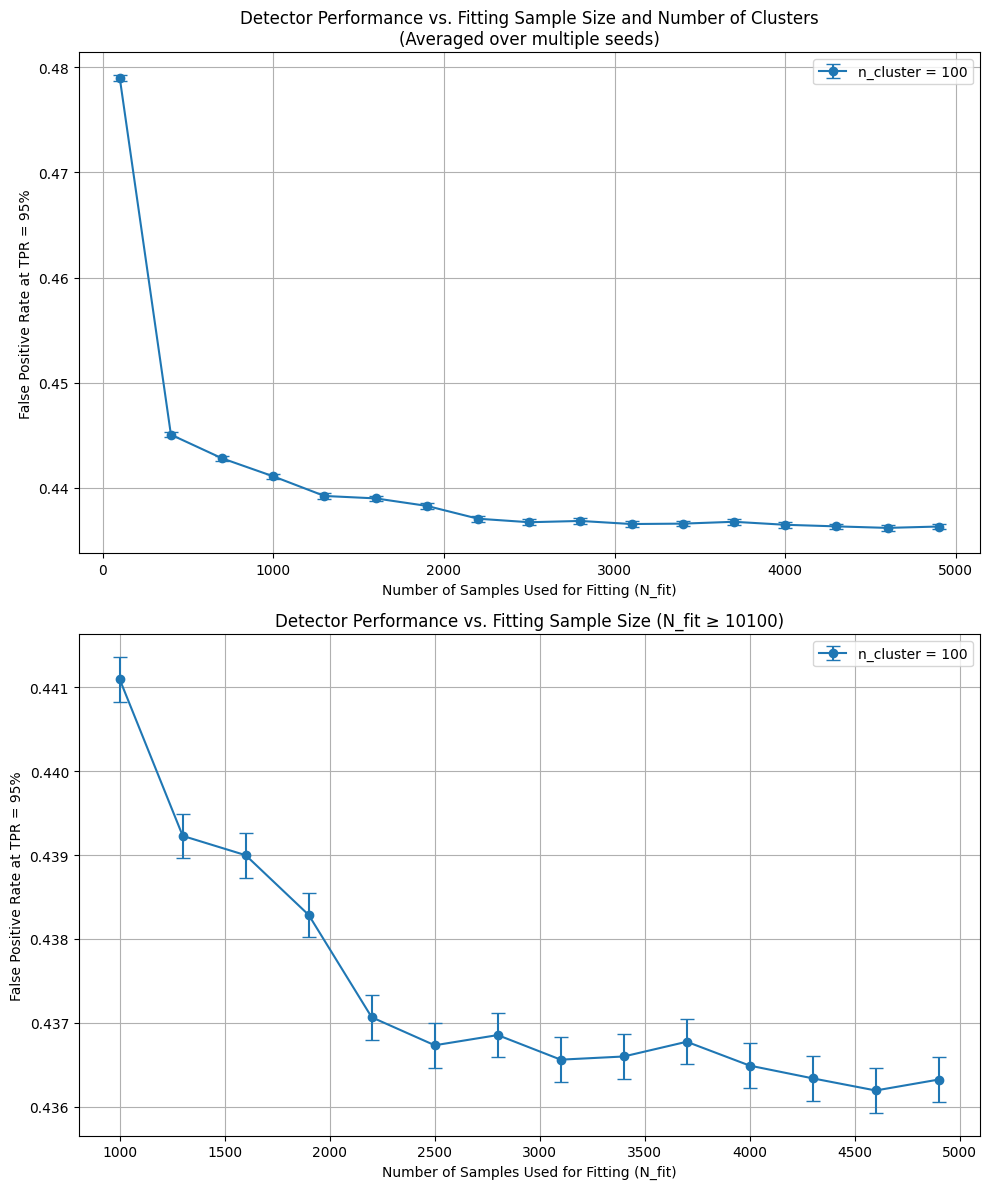

In [237]:
# -----------------------------
# Define the different N_fit sample sizes and number of clusters to try
N_fit_vals = range(100, 5000, 300)
n_clusters_range = [100]

# Define a list of seeds for repeating the experiment (you can adjust the number and values here)
seed_list = np.arange(200)
n_seed = len(seed_list)

# For each n_cluster and each N_fit, we will record FPRs across different experiment runs.
# Here we use a nested dictionary: keys are n_cluster and then N_fit
performance_results = {n_cluster: {N_fit: [] for N_fit in N_fit_vals} for n_cluster in n_clusters_range}
# variance results
var_results = {n_cluster: {N_fit: [] for N_fit in N_fit_vals} for n_cluster in n_clusters_range}

# Use the maximum N_fit for generating a fitting dataset
max_N_fit = max(N_fit_vals)

# Evaluation dataset size remains fixed for all experiments
N_eval = 20000

# -----------------------------
# Experiment Loop: Over Different Seeds
# -----------------------------
for seed in seed_list:
    # Generate a new fixed fitting dataset and evaluation dataset for this run.
    # (Optionally, you could use different seeds for fitting and evaluation; here we use seed and a shifted value.)
    fitting_data_full = generate(max_N_fit, weights, means, std, seed=seed)
    evaluation_data = generate(N_eval, weights, means, std, seed=seed + 1000)

    # Loop over the different fitting sample sizes
    for N_fit in N_fit_vals:
        # Use the first N_fit samples from the fitting dataset
        fitting_data = fitting_data_full[:N_fit]

        # Loop over the different n_cluster choices
        print("N_fit", N_fit)
        print("seed", seed)
        for n_cluster in n_clusters_range:
            # Instantiate the detector. Here we also pass the current seed.
            detector = PartitionDetector(classifier, weights, means, std,
                                         n_cluster=n_cluster, alpha=0.05, seed=seed)

            # --- Fit the Detector on the Current Fitting Dataset ---
            inputs = fitting_data[:, 0]
            # Get classifier predictions and compute error flags for each training sample.
            classif_preds = np.array([classifier(x) for x in inputs])
            errors = (classif_preds != fitting_data[:, 1])
            # Get the estimated error probabilities from the provided function.
            proba_error_vals = np.array([func_proba_error(x, classifier) for x in inputs])
            # Allocate each sample to a cluster by scaling to the number of clusters.
            clusters = np.floor(proba_error_vals * n_cluster).astype(int)
            clusters[clusters == n_cluster] = n_cluster - 1

            # Initialize lists to hold per-cluster statistics.
            cluster_counts = []
            cluster_error_means = []
            cluster_error_vars = []
            cluster_intervals = []

            # Compute statistics for each cluster.
            for i in range(n_cluster):
                idx = np.where(clusters == i)[0]
                count = idx.size
                cluster_counts.append(count)
                if count > 0:
                    error_mean = np.mean(errors[idx])
                    cluster_error_means.append(error_mean)
                    # Compute the half-width of the confidence interval based on count and alpha.
                    half_width = np.sqrt(np.log(2 / detector.alpha) / (2 * count))
                    lower_bound = max(0.0, error_mean - half_width)
                    upper_bound = min(1.0, error_mean + half_width)
                    cluster_intervals.append((lower_bound, upper_bound))
                    # Optionally, compute the variance if needed.
                    cluster_error_vars.append(np.var(errors[idx]))
                else:
                    cluster_error_means.append(0.0)
                    cluster_error_vars.append(0.0)
                    cluster_intervals.append((0, 1))

            # Update the detector with the computed statistics.
            detector.cluster_counts = cluster_counts
            detector.cluster_error_means = cluster_error_means
            detector.cluster_error_vars = cluster_error_vars  # or assign to detector.cluster_vars if that’s the attribute name
            detector.cluster_intervals = cluster_intervals

            # --- Evaluate Performance on the Evaluation Dataset ---
            eval_inputs = evaluation_data[:, 0]
            eval_classifier_preds = np.array([classifier(x) for x in eval_inputs])
            error_flags = (eval_classifier_preds != evaluation_data[:, 1])
            # Compute detector outputs for each evaluation sample.
            detector_outputs = np.array([detector(x) for x in eval_inputs])
            # Obtain ROC curve values based on the detector outputs.
            fprs, tprs, thresholds = roc_curve(error_flags, detector_outputs)
            fpr_val, tpr_val, thr_val = fpr_at_fixed_tpr(fprs, tprs, thresholds, tpr_level=0.95)
    
            print("fpr_val", fpr_val)
            print("tpr_val", tpr_val)
            print("thr_val", thr_val)
            n_negatif = np.sum(error_flags == 0)
            var_fpr = fpr_val * (1 - fpr_val) / n_negatif

            # Record the performance for this (n_cluster, N_fit) configuration for the current seed.
            performance_results[n_cluster][N_fit].append(fpr_val)
            var_results[n_cluster][N_fit].append(var_fpr)

# # # -----------------------------
# Aggregating Results and Plotting
# -----------------------------
N_fit_vals_sub = [N for N in N_fit_vals if N >= 1000]

# Create a figure with 2 subplots, one above the other.
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# -----------------------------
# Plot 1: Full Range of N_fit Values
# -----------------------------
for n_cluster in n_clusters_range:
    avg_fpr = []
    std_fpr = []
    for N_fit in N_fit_vals:
        fpr_vals = np.array(performance_results[n_cluster][N_fit])
        avg_fpr.append(np.mean(fpr_vals))
        std_fpr.append(np.sqrt(np.sum(var_results[n_cluster][N_fit]) / (n_seed ** 2)))
    axs[0].errorbar(N_fit_vals, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
                    label=f'n_cluster = {n_cluster}')
    
axs[0].set_xlabel('Number of Samples Used for Fitting (N_fit)')
axs[0].set_ylabel('False Positive Rate at TPR = 95%')
axs[0].set_title('Detector Performance vs. Fitting Sample Size and Number of Clusters\n(Averaged over multiple seeds)')
axs[0].legend()
axs[0].grid(True)

# -----------------------------
# Plot 2: N_fit Values Starting at 10100
# -----------------------------
for n_cluster in n_clusters_range:
    avg_fpr = []
    std_fpr = []
    for N_fit in N_fit_vals_sub:
        fpr_vals = np.array(performance_results[n_cluster][N_fit])
        avg_fpr.append(np.mean(fpr_vals))
        std_fpr.append(np.sqrt(np.sum(var_results[n_cluster][N_fit]) / (n_seed ** 2)))
    axs[1].errorbar(N_fit_vals_sub, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
                    label=f'n_cluster = {n_cluster}')
    
axs[1].set_xlabel('Number of Samples Used for Fitting (N_fit)')
axs[1].set_ylabel('False Positive Rate at TPR = 95%')
axs[1].set_title('Detector Performance vs. Fitting Sample Size (N_fit ≥ 10100)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


fpr_val 0.43444804443415874
tpr_val 0.9558173784977909
thr_val 0.7841002756996854
fpr_val 0.43444804443415874
tpr_val 0.9558173784977909
thr_val 0.3920501378498427
fpr_val 0.43444804443415874
tpr_val 0.9558173784977909
thr_val 0.28128761185103157
fpr_val 0.44727300779140633
tpr_val 0.9579037800687286
thr_val 0.2687523396774872
fpr_val 0.43444804443415874
tpr_val 0.9558173784977909
thr_val 0.21949000738832564
fpr_val 0.43444804443415874
tpr_val 0.9558173784977909
thr_val 0.21663768946757744
fpr_val 0.44727300779140633
tpr_val 0.9579037800687286
thr_val 0.19726377895048325
fpr_val 0.44727300779140633
tpr_val 0.9579037800687286
thr_val 0.1959396969792967
fpr_val 0.44727300779140633
tpr_val 0.9579037800687286
thr_val 0.18236140793824207
fpr_val 0.44727300779140633
tpr_val 0.9579037800687286
thr_val 0.1886013698049555
fpr_val 0.44727300779140633
tpr_val 0.9579037800687286
thr_val 0.1797265826560847
fpr_val 0.44727300779140633
tpr_val 0.9579037800687286
thr_val 0.17567512631171828
fpr_val 0.

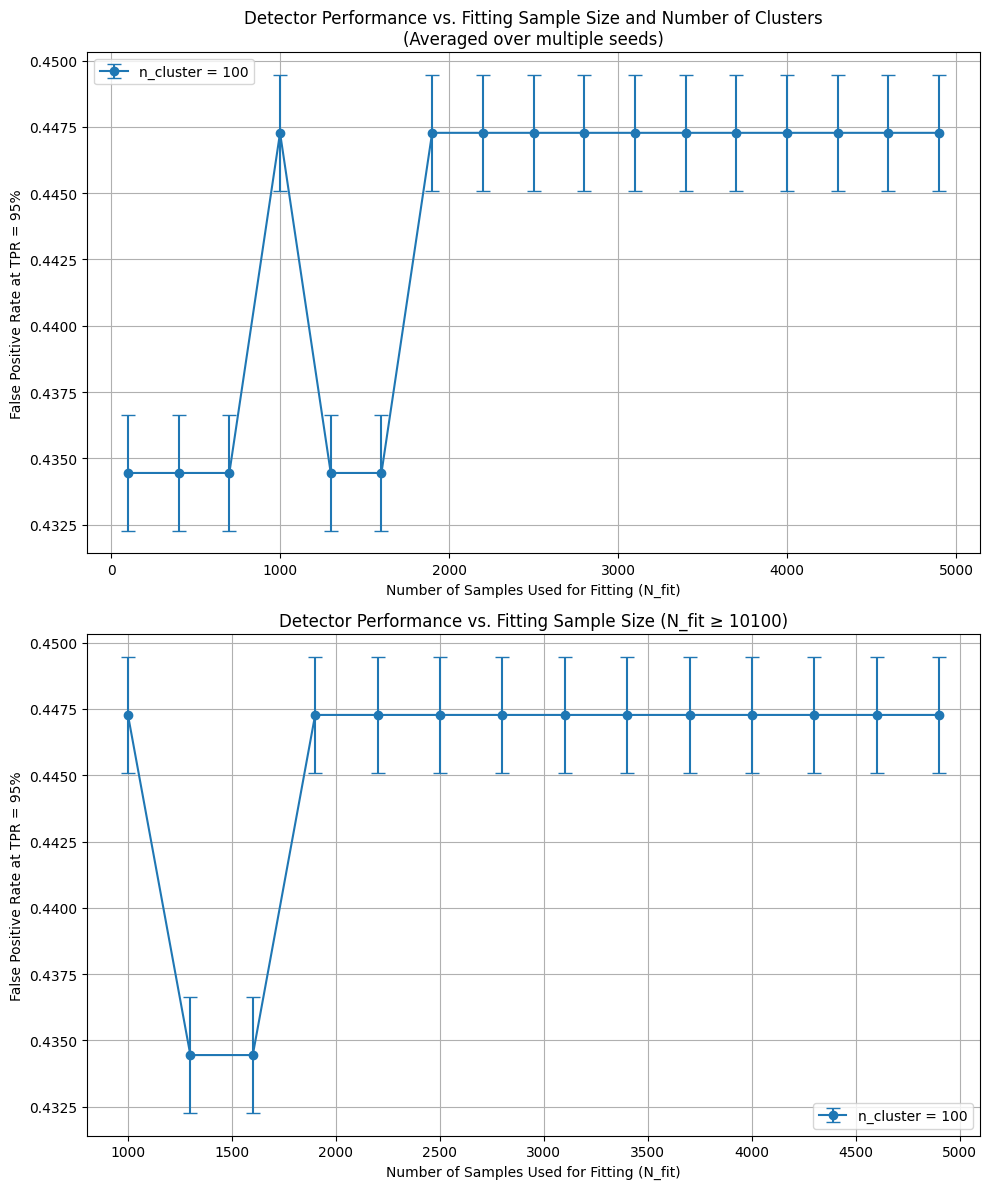

In [48]:
# -----------------------------
# Define the different N_fit sample sizes and number of clusters to try
N_fit_vals = range(100, 5000, 300)
n_clusters_range = [100]

# Define a list of seeds for repeating the experiment (you can adjust the number and values here)
seed_list = [107]
n_seed = len(seed_list)

# For each n_cluster and each N_fit, we will record FPRs across different experiment runs.
# Here we use a nested dictionary: keys are n_cluster and then N_fit
performance_results = {n_cluster: {N_fit: [] for N_fit in N_fit_vals} for n_cluster in n_clusters_range}
# variance results
var_results = {n_cluster: {N_fit: [] for N_fit in N_fit_vals} for n_cluster in n_clusters_range}

# Use the maximum N_fit for generating a fitting dataset
max_N_fit = max(N_fit_vals)

# Evaluation dataset size remains fixed for all experiments
N_eval = 60000

# -----------------------------
# Experiment Loop: Over Different Seeds
# -----------------------------
for seed in seed_list:
    # Generate a new fixed fitting dataset and evaluation dataset for this run.
    # (Optionally, you could use different seeds for fitting and evaluation; here we use seed and a shifted value.)
    fitting_data_full = generate(max_N_fit, weights, means, std, seed=seed)
    evaluation_data = generate(N_eval, weights, means, std, seed=seed + 1000)

    # Loop over the different fitting sample sizes
    for N_fit in N_fit_vals:
        # Use the first N_fit samples from the fitting dataset
        fitting_data = fitting_data_full[:N_fit]

        # Loop over the different n_cluster choices
        for n_cluster in n_clusters_range:
            # Instantiate the detector. Here we also pass the current seed.
            detector = PartitionDetector(classifier, weights, means, std,
                                         n_cluster=n_cluster, alpha=0.05, seed=seed)

            # --- Fit the Detector on the Current Fitting Dataset ---
            inputs = fitting_data[:, 0]
            # Get classifier predictions and compute error flags for each training sample.
            classif_preds = np.array([classifier(x) for x in inputs])
            errors = (classif_preds != fitting_data[:, 1])
            # Get the estimated error probabilities from the provided function.
            proba_error_vals = np.array([func_proba_error(x, classifier) for x in inputs])
            # Allocate each sample to a cluster by scaling to the number of clusters.
            clusters = np.floor(proba_error_vals * n_cluster).astype(int)
            clusters[clusters == n_cluster] = n_cluster - 1

            # Initialize lists to hold per-cluster statistics.
            cluster_counts = []
            cluster_error_means = []
            cluster_error_vars = []
            cluster_intervals = []

            # Compute statistics for each cluster.
            for i in range(n_cluster):
                idx = np.where(clusters == i)[0]
                count = idx.size
                cluster_counts.append(count)
                if count > 0:
                    error_mean = np.mean(errors[idx])
                    cluster_error_means.append(error_mean)
                    # Compute the half-width of the confidence interval based on count and alpha.
                    half_width = np.sqrt(np.log(2 / detector.alpha) / (2 * count))
                    lower_bound = max(0.0, error_mean - half_width)
                    upper_bound = min(1.0, error_mean + half_width)
                    cluster_intervals.append((lower_bound, upper_bound))
                    # Optionally, compute the variance if needed.
                    cluster_error_vars.append(np.var(errors[idx]))
                else:
                    cluster_error_means.append(0.0)
                    cluster_error_vars.append(0.0)
                    cluster_intervals.append((0, 1))

            # Update the detector with the computed statistics.
            detector.cluster_counts = cluster_counts
            detector.cluster_error_means = cluster_error_means
            detector.cluster_error_vars = cluster_error_vars  # or assign to detector.cluster_vars if that’s the attribute name
            detector.cluster_intervals = cluster_intervals

            # --- Evaluate Performance on the Evaluation Dataset ---
            eval_inputs = evaluation_data[:, 0]
            eval_classifier_preds = np.array([classifier(x) for x in eval_inputs])
            error_flags = (eval_classifier_preds != evaluation_data[:, 1])
            # Compute detector outputs for each evaluation sample.
            detector_outputs = np.array([detector(x) for x in eval_inputs])
            # Obtain ROC curve values based on the detector outputs.
            fprs, tprs, thresholds = roc_curve(error_flags, detector_outputs)
            fpr_val, tpr_val, thr_val = fpr_at_fixed_tpr(fprs, tprs, thresholds, tpr_level=0.95)
    
            print("fpr_val", fpr_val)
            print("tpr_val", tpr_val)
            print("thr_val", thr_val)
            n_negatif = np.sum(error_flags == 0)
            var_fpr = fpr_val * (1 - fpr_val) / n_negatif

            # Record the performance for this (n_cluster, N_fit) configuration for the current seed.
            performance_results[n_cluster][N_fit].append(fpr_val)
            var_results[n_cluster][N_fit].append(var_fpr)

# # # -----------------------------
# Aggregating Results and Plotting
# -----------------------------
N_fit_vals_sub = [N for N in N_fit_vals if N >= 1000]

# Create a figure with 2 subplots, one above the other.
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# -----------------------------
# Plot 1: Full Range of N_fit Values
# -----------------------------
for n_cluster in n_clusters_range:
    avg_fpr = []
    std_fpr = []
    for N_fit in N_fit_vals:
        fpr_vals = np.array(performance_results[n_cluster][N_fit])
        avg_fpr.append(np.mean(fpr_vals))
        std_fpr.append(np.sqrt(np.sum(var_results[n_cluster][N_fit]) / (n_seed ** 2)))
    axs[0].errorbar(N_fit_vals, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
                    label=f'n_cluster = {n_cluster}')
    
axs[0].set_xlabel('Number of Samples Used for Fitting (N_fit)')
axs[0].set_ylabel('False Positive Rate at TPR = 95%')
axs[0].set_title('Detector Performance vs. Fitting Sample Size and Number of Clusters\n(Averaged over multiple seeds)')
axs[0].legend()
axs[0].grid(True)

# -----------------------------
# Plot 2: N_fit Values Starting at 10100
# -----------------------------
for n_cluster in n_clusters_range:
    avg_fpr = []
    std_fpr = []
    for N_fit in N_fit_vals_sub:
        fpr_vals = np.array(performance_results[n_cluster][N_fit])
        avg_fpr.append(np.mean(fpr_vals))
        std_fpr.append(np.sqrt(np.sum(var_results[n_cluster][N_fit]) / (n_seed ** 2)))
    axs[1].errorbar(N_fit_vals_sub, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
                    label=f'n_cluster = {n_cluster}')
    
axs[1].set_xlabel('Number of Samples Used for Fitting (N_fit)')
axs[1].set_ylabel('False Positive Rate at TPR = 95%')
axs[1].set_title('Detector Performance vs. Fitting Sample Size (N_fit ≥ 10100)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


seed 107 fpr 0.5606721136357075
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 107 fpr 0.43130178710627365
seed 108 fpr 0.43130178710627365
seed 108 fpr 0.43130178710627365
seed 108 fpr 0.43130178710627365
seed 108 fpr 0.43130178710627365
seed 108 fpr 0.43130178710627365
seed 108 fpr 0.43130178710627365
seed 108 fpr 0.43130178710627365
seed 108 fpr 0.43130178710627365
seed 108 fpr 0.43130178710627365
seed 108 fpr 0.43130178710627365
seed 108 fpr 0.43130178710627365
seed 108 fpr 0.43130178710627365
seed 108 fpr 0.43130178710627365
seed 108 fp

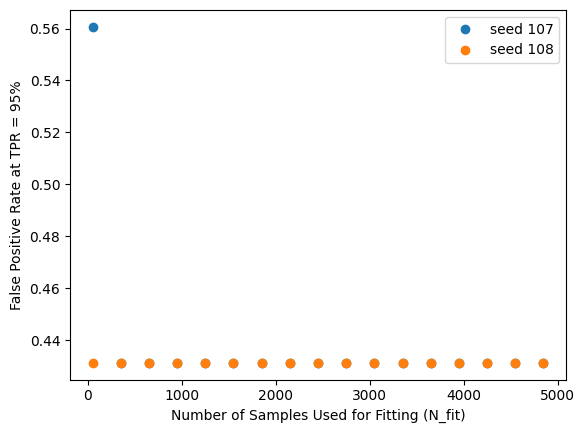

In [58]:

import copy
# -----------------------------
# Define the different N_fit sample sizes and number of clusters to try
N_fit_vals = range(50, 5000, 300)
n_clusters_range = [50]

# Define a list of seeds for repeating the experiment (you can adjust the number and values here)
seed_list = [107, 108,109]
n_seed = len(seed_list)

# For each n_cluster and each N_fit, we will record FPRs across different experiment runs.
# Here we use a nested dictionary: keys are n_cluster and then N_fit
performance_results = {
    seed: [] for seed in seed_list}
# variance results


detectors = {N_fit: [] for N_fit in N_fit_vals}
detectors_soft = {N_fit: [] for N_fit in N_fit_vals}

# Use the maximum N_fit for generating a fitting dataset
max_N_fit = max(N_fit_vals)

# Evaluation dataset size remains fixed for all experiments
N_eval = 40000

# -----------------------------
# Experiment Loop: Over Different Seeds
# -----------------------------
plt.figure()
for seed in seed_list:
    # Generate a new fixed fitting dataset and evaluation dataset for this run.
    # (Optionally, you could use different seeds for fitting and evaluation; here we use seed and a shifted value.)
    fitting_data_full = generate(max_N_fit, weights, means, std, seed=seed)
    evaluation_data = generate(N_eval, weights, means, std, seed=1)

    # Loop over the different fitting sample sizes
    for N_fit in N_fit_vals:
        # Use the first N_fit samples from the fitting dataset
        fitting_data = fitting_data_full[:N_fit]
        for n_cluster in n_clusters_range:
            # Instantiate the detector. Here we also pass the current seed.
            detector = PartitionDetector(classifier, weights, means, std,
                                         n_cluster=n_cluster, alpha=0.05, seed=seed)

            # --- Fit the Detector on the Current Fitting Dataset ---
            inputs = fitting_data[:, 0]
            # Get classifier predictions and compute error flags for each training sample.
            classif_preds = np.array([classifier(x) for x in inputs])
            errors = (classif_preds != fitting_data[:, 1])
            # Get the estimated error probabilities from the provided function.
            proba_error_vals = np.array([func_proba_error(x, classifier) for x in inputs])
            # Allocate each sample to a cluster by scaling to the number of clusters.
            clusters = np.floor(proba_error_vals * n_cluster).astype(int)
            clusters[clusters == n_cluster] = n_cluster - 1

            # Initialize lists to hold per-cluster statistics.
            cluster_counts = []
            cluster_error_means = []
            cluster_error_vars = []
            cluster_intervals = []

            # Compute statistics for each cluster.
            for i in range(n_cluster):
                idx = np.where(clusters == i)[0]
                count = idx.size
                cluster_counts.append(count)
                if count > 0:
                    error_mean = np.mean(errors[idx])
                    cluster_error_means.append(error_mean)
                    # Compute the half-width of the confidence interval based on count and alpha.
                    half_width = np.sqrt(np.log(2 / detector.alpha) / (2 * count))
                    lower_bound = max(0.0, error_mean - half_width)
                    upper_bound = min(1.0, error_mean + half_width)
                    cluster_intervals.append((lower_bound, upper_bound))
                    # Optionally, compute the variance if needed.
                    cluster_error_vars.append(np.var(errors[idx]))
                else:
                    cluster_error_means.append(0.0)
                    cluster_error_vars.append(0.0)
                    cluster_intervals.append((0, 1))

            # Update the detector with the computed statistics.
            detector.cluster_counts = cluster_counts
            detector.cluster_error_means = cluster_error_means
            detector.cluster_error_vars = cluster_error_vars  # or assign to detector.cluster_vars if that’s the attribute name
            detector.cluster_intervals = cluster_intervals

            # --- Evaluate Performance on the Evaluation Dataset ---
            eval_inputs = evaluation_data[:, 0]
            eval_classifier_preds = np.array([classifier(x) for x in eval_inputs])
            error_flags = (eval_classifier_preds != evaluation_data[:, 1])
            # Compute detector outputs for each evaluation sample.
            detector_outputs = np.array([detector(x) for x in eval_inputs])
            # Obtain ROC curve values based on the detector outputs.
            fprs, tprs, thresholds = roc_curve(error_flags, detector_outputs)

            fpr_val, tpr_val, thr_val = fpr_at_fixed_tpr(fprs, tprs, thresholds, tpr_level=0.95)

            detectors[N_fit].append(lambda x, detector=detector, thr_val=thr_val: 1 if detector(x) >= thr_val else 0)

            detectors_soft[N_fit].append(copy.deepcopy(detector))

            n_negatif = np.sum(error_flags == 0)
            var_fpr = fpr_val * (1 - fpr_val) / n_negatif
            print("seed", seed, 'fpr', fpr_val)

            # Record the performance for this (n_cluster, N_fit) configuration for the current seed.
            performance_results[seed].append(fpr_val)

plt.plot(N_fit_vals, performance_results[seed_list[0]], 'o', label='seed 107')
plt.plot(N_fit_vals, performance_results[seed_list[1]], 'o', label='seed 108')
plt.xlabel('Number of Samples Used for Fitting (N_fit)')
plt.ylabel('False Positive Rate at TPR = 95%')
plt.legend()

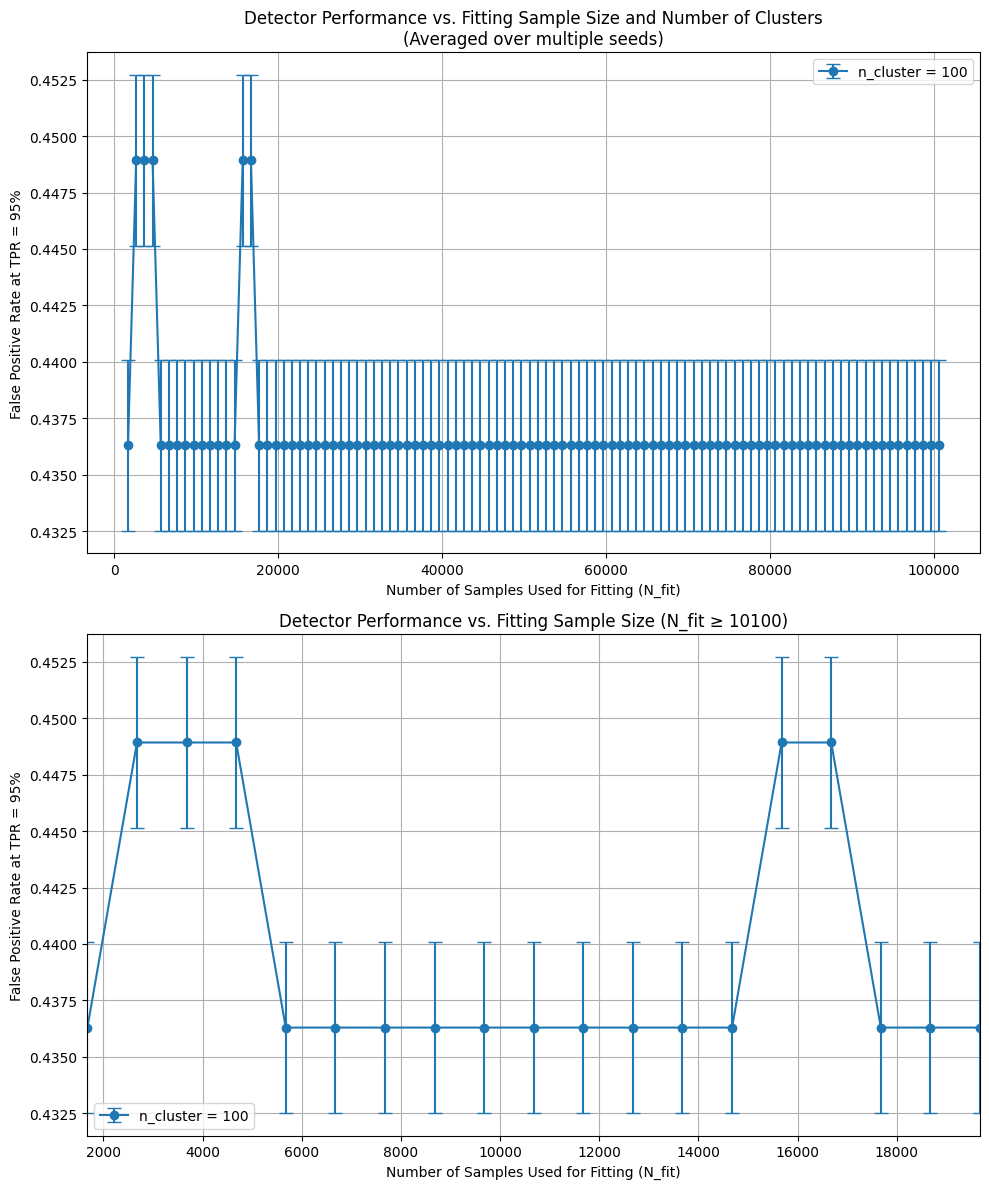

In [ ]:

import copy
# -----------------------------
# Define the different N_fit sample sizes and number of clusters to try
N_fit_vals = range(100, 5000, 300)
N_fit_vals = [1678, 1679, 1680]
N_fit_vals = [1678 + i * 1000 for i in range(100)]
n_clusters_range = list(range(100, 1100, 100))
n_clusters_range = [100]

# Define a list of seeds for repeating the experiment (you can adjust the number and values here)
seed_list = {107}
n_seed = len(seed_list)

# For each n_cluster and each N_fit, we will record FPRs across different experiment runs.
# Here we use a nested dictionary: keys are n_cluster and then N_fit
performance_results = {n_cluster: {N_fit: [] for N_fit in N_fit_vals} for n_cluster in n_clusters_range}
# variance results
var_results = {n_cluster: {N_fit: [] for N_fit in N_fit_vals} for n_cluster in n_clusters_range}

detectors = {N_fit: [] for N_fit in N_fit_vals}
detectors_soft = {N_fit: [] for N_fit in N_fit_vals}

# Use the maximum N_fit for generating a fitting dataset
max_N_fit = max(N_fit_vals)

# Evaluation dataset size remains fixed for all experiments
N_eval = 20000

# -----------------------------
# Experiment Loop: Over Different Seeds
# -----------------------------
# plt.figure()
for seed in seed_list:
    # Generate a new fixed fitting dataset and evaluation dataset for this run.
    # (Optionally, you could use different seeds for fitting and evaluation; here we use seed and a shifted value.)
    fitting_data_full = generate(max_N_fit, weights, means, std, seed=seed)
    evaluation_data = generate(N_eval, weights, means, std, seed=seed + 1000)

    # Loop over the different fitting sample sizes
    for N_fit in N_fit_vals:
        # Use the first N_fit samples from the fitting dataset
        fitting_data = fitting_data_full[:N_fit]

        # Loop over the different n_cluster choices
        print("N_fit", N_fit)
        print("seed", seed)
        for n_cluster in n_clusters_range:
            # Instantiate the detector. Here we also pass the current seed.
            detector = PartitionDetector(classifier, weights, means, std,
                                         n_cluster=n_cluster, alpha=0.05, seed=seed)

            # --- Fit the Detector on the Current Fitting Dataset ---
            inputs = fitting_data[:, 0]
            # Get classifier predictions and compute error flags for each training sample.
            classif_preds = np.array([classifier(x) for x in inputs])
            errors = (classif_preds != fitting_data[:, 1])
            # Get the estimated error probabilities from the provided function.
            proba_error_vals = np.array([func_proba_error(x, classifier) for x in inputs])
            # Allocate each sample to a cluster by scaling to the number of clusters.
            clusters = np.floor(proba_error_vals * n_cluster).astype(int)
            clusters[clusters == n_cluster] = n_cluster - 1

            # Initialize lists to hold per-cluster statistics.
            cluster_counts = []
            cluster_error_means = []
            cluster_error_vars = []
            cluster_intervals = []

            # Compute statistics for each cluster.
            for i in range(n_cluster):
                idx = np.where(clusters == i)[0]
                count = idx.size
                cluster_counts.append(count)
                if count > 0:
                    error_mean = np.mean(errors[idx])
                    cluster_error_means.append(error_mean)
                    # Compute the half-width of the confidence interval based on count and alpha.
                    half_width = np.sqrt(np.log(2 / detector.alpha) / (2 * count))
                    lower_bound = max(0.0, error_mean - half_width)
                    upper_bound = min(1.0, error_mean + half_width)
                    cluster_intervals.append((lower_bound, upper_bound))
                    # Optionally, compute the variance if needed.
                    cluster_error_vars.append(np.var(errors[idx]))
                else:
                    cluster_error_means.append(0.0)
                    cluster_error_vars.append(0.0)
                    cluster_intervals.append((0, 1))

            # Update the detector with the computed statistics.
            detector.cluster_counts = cluster_counts
            detector.cluster_error_means = cluster_error_means
            detector.cluster_error_vars = cluster_error_vars  # or assign to detector.cluster_vars if that’s the attribute name
            detector.cluster_intervals = cluster_intervals

            # --- Evaluate Performance on the Evaluation Dataset ---
            eval_inputs = evaluation_data[:, 0]
            eval_classifier_preds = np.array([classifier(x) for x in eval_inputs])
            error_flags = (eval_classifier_preds != evaluation_data[:, 1])
            # Compute detector outputs for each evaluation sample.
            detector_outputs = np.array([detector(x) for x in eval_inputs])
            # Obtain ROC curve values based on the detector outputs.
            fprs, tprs, thresholds = roc_curve(error_flags, detector_outputs)
            # print(fprs)
            # plt.plot(fprs, tprs, marker='.', label=f'ROC curve (n_cluster={n_cluster}, N_fit={N_fit})')
            # plt.xlabel('False Positive Rate')
            # plt.ylabel('True Positive Rate')
            # plt.title('Receiver Operating Characteristic (ROC) Curve')
            # plt.legend()
            # plt.grid()

            fpr_val, tpr_val, thr_val = fpr_at_fixed_tpr(fprs, tprs, thresholds, tpr_level=0.95)

            detectors[N_fit].append(lambda x, detector=detector, thr_val=thr_val: 1 if detector(x) >= thr_val else 0)

            detectors_soft[N_fit].append(copy.deepcopy(detector))
            print("fpr_val", fpr_val)
            print("tpr_val", tpr_val)
            print("thr_val", thr_val)
            n_negatif = np.sum(error_flags == 0)
            var_fpr = fpr_val * (1 - fpr_val) / n_negatif

            # Record the performance for this (n_cluster, N_fit) configuration for the current seed.
            performance_results[n_cluster][N_fit].append(fpr_val)
            var_results[n_cluster][N_fit].append(var_fpr)

# # # # -----------------------------
# # Aggregating Results and Plotting
# -----------------------------
N_fit_vals_sub = [N for N in N_fit_vals if N >= 1000 and N < 20000]

# Create a figure with 2 subplots, one above the other.
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# -----------------------------
# Plot 1: Full Range of N_fit Values
# -----------------------------
for n_cluster in n_clusters_range:
    avg_fpr = []
    std_fpr = []
    for N_fit in N_fit_vals:
        fpr_vals = np.array(performance_results[n_cluster][N_fit])
        avg_fpr.append(np.mean(fpr_vals))
        std_fpr.append(np.sqrt(np.sum(var_results[n_cluster][N_fit]) / (n_seed ** 2)))
    axs[0].errorbar(N_fit_vals, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
                    label=f'n_cluster = {n_cluster}')
    
axs[0].set_xlabel('Number of Samples Used for Fitting (N_fit)')
axs[0].set_ylabel('False Positive Rate at TPR = 95%')
axs[0].set_title('Detector Performance vs. Fitting Sample Size and Number of Clusters\n(Averaged over multiple seeds)')
axs[0].legend()
axs[0].grid(True)

# -----------------------------
# Plot 2: N_fit Values Starting at 10100
# -----------------------------
for n_cluster in n_clusters_range:
    avg_fpr = []
    std_fpr = []
    for N_fit in N_fit_vals_sub:
        fpr_vals = np.array(performance_results[n_cluster][N_fit])
        avg_fpr.append(np.mean(fpr_vals))
        std_fpr.append(np.sqrt(np.sum(var_results[n_cluster][N_fit]) / (n_seed ** 2)))
    axs[1].errorbar(N_fit_vals_sub, avg_fpr, yerr=std_fpr, marker='o', capsize=5,
                    label=f'n_cluster = {n_cluster}')
    
axs[1].set_xlabel('Number of Samples Used for Fitting (N_fit)')
axs[1].set_ylabel('False Positive Rate at TPR = 95%')
axs[1].set_xlim(N_fit_vals_sub[0], N_fit_vals_sub[-1])
axs[1].set_title('Detector Performance vs. Fitting Sample Size (N_fit ≥ 10100)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


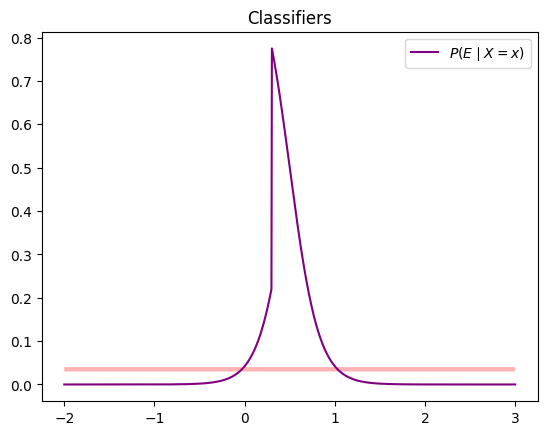

In [51]:

n_cluster = 100
xs = np.linspace(-2, 3, 1000)
bin_number = 3
y_min_bin = 3 / n_cluster
y_max_bin = (3 +1) / n_cluster

# plt.plot(x, [classifier(x, threshold) for x in xs],
#           label=f'Threshold = {threshold} - Risk - {total_proba_error(threshold):.2}', color='green')
# plt.plot(x, [bayes_hard_detector(x) for x in xs],
#           label='Bayes Detector', color='orange')
# plt.fill_between(xs, 0, 1, where=mask_detector, facecolor='red', alpha=0.3, label = "Error Detector",
#                  transform=plt.gca().get_xaxis_transform())
# plt.plot(x, [neyman_pearson_detector(x) for x in xs],
#           label="detector", color='black')
# plt.plot(x, [bayes_classifier(x) for x in xs],
#           label='Bayes classifier', color='orange')
plt.plot(xs, [func_proba_error(x, classifier) for x in xs],
          label=r'$P(E \mid X=x)$', color='purple')
plt.fill_between(xs, y_min_bin, y_max_bin, facecolor='red', alpha=0.3)

# plt.plot(x, [density_conditionnal_error(x, weights, means, std, threshold) for x in xs],
#          label = r'$p(x \mid E)$', color='black')
# plt.plot(x, [density_conditionnal_no_error(x, weights, means, std, threshold) for x in xs],
#          label = r'$p(x \mid E^c)$', color='blue')
# plt.plot(x, [total_proba_no_error(threshold, weights, means, std) * density_conditionnal_no_error(x, weights, means, std, threshold) + total_proba_error(threshold, weights, means, std) * density_conditionnal_error(x, weights, means, std, threshold) for x in xs],
#          label = 'test', color='pink')
# plt.plot(x, mixture_pdf(x, means, std, weights), label='Mixture PDF', linestyle="--", color='black')

# plt.plot(x, mixture_cond_pdf(x, 1, means, std, weights), label='P(Y=1|X=x)', linestyle="--", linewidth=0.7, color='red')
# plt.plot(x, mixture_cond_pdf(x, 0, means, std, weights), label='P(Y=0|X=x)', linestyle="--", linewidth=0.7,color='blue')
plt.title('Classifiers')
plt.legend()

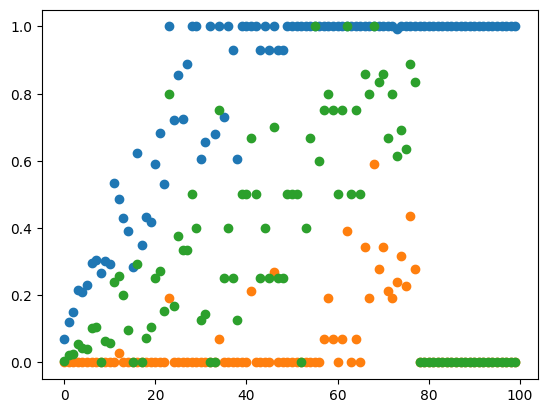

In [52]:

plt.plot(np.array(detectors_soft[1679][0].cluster_intervals)[:,1], 'o', label='cluster error means')
plt.plot(np.array(detectors_soft[1679][0].cluster_intervals)[:,0], 'o', label='cluster error means')
plt.plot(np.array(detectors_soft[1679][0].cluster_error_means), 'o', label='cluster error means')

In [18]:
eval_inputs = evaluation_data[:, 0]
detectors_1600 = np.array([detectors[1678][0](x) for x in eval_inputs])
detectors_1900 = np.array([detectors[1679][0](x) for x in eval_inputs])
np.where(detectors_1900 != detectors_1600)[0]
idx = np.where(detectors_1900 != detectors_1600)[0]
print("idx", idx)
print("clusters", np.unique([detectors_soft[1679][0].predict_clusters(x) for x in eval_inputs[idx]]))

idx [   14    34    50 ... 19977 19982 19988]
clusters [3 4]


In [51]:
for seed in [1107 + i for i in range(4)]:
    print("seed", seed)
    _, _ ,_, _ = evaluate_detector(model, detectors_soft[1678][0], weights, means, std, seed=seed, N=100000)
    _, _ ,_, _ = evaluate_detector(model, detectors_soft[1679][0], weights, means, std, seed=seed, N=100000)

seed 1107
fpr_val 0.4348274025883824
tpr_val 0.957543705009549
thr_val 0.2088116470502947
fpr_val 0.44702845368462485
tpr_val 0.958425150580285
thr_val 0.21560935410887566
seed 1108
fpr_val 0.43090566865668195
tpr_val 0.9592567718826953
thr_val 0.2088116470502947
fpr_val 0.44544394277070176
tpr_val 0.9568688903813148
thr_val 0.21560935410887566
seed 1109
fpr_val 0.43493265313188906
tpr_val 0.9547121790553185
thr_val 0.2088116470502947
fpr_val 0.44578202005978695
tpr_val 0.9547121790553185
thr_val 0.21560935410887566
seed 1110
fpr_val 0.43429546292880855
tpr_val 0.9584842995169082
thr_val 0.2088116470502947
fpr_val 0.44470444485429733
tpr_val 0.9578049516908212
thr_val 0.21560935410887566


In [61]:
new_point = fitting_data_full[1678]
cluster_new_point = detectors_soft[1678][0].predict_clusters(new_point[0])
print("cluster_new_point", cluster_new_point)

print(f"cluster {cluster_new_point} counts before", detectors_soft[1678][0].cluster_counts[cluster_new_point])
print(f"cluster {cluster_new_point} counts after", detectors_soft[1679][0].cluster_counts[cluster_new_point])
print(f"cluster {cluster_new_point} mean before", detectors_soft[1678][0].cluster_error_means[cluster_new_point])
print(f"cluster {cluster_new_point} mean after", detectors_soft[1679][0].cluster_error_means[cluster_new_point])
print(f"cluster {cluster_new_point} intervals before", detectors_soft[1678][0].cluster_intervals[cluster_new_point])
print(f"cluster {cluster_new_point} intervals after", detectors_soft[1679][0].cluster_intervals[cluster_new_point])

cluster_new_point 3
cluster 3 counts before 71
cluster 3 counts after 72
cluster 3 mean before 0.04225352112676056
cluster 3 mean after 0.05555555555555555
cluster 3 intervals before (0.0, np.float64(0.20343051801138437))
cluster 3 intervals after (0.0, np.float64(0.21560935410887566))


In [301]:
eval_inputs = evaluation_data[:, 0]
detectors_1600 = np.array([detectors[1600][0](x) for x in eval_inputs])
detectors_1900 = np.array([detectors[1900][0](x) for x in eval_inputs])
idx = np.where(detectors_1900 != detectors_1600)[0]

In [304]:
np.unique([detectors_soft[1600][0].predict_clusters(x) for x in eval_inputs[idx]])

array([3, 4])

In [312]:
print(detectors_soft[1600][0].cluster_intervals[3])
print(detectors_soft[1900][0].cluster_intervals[3])

(0.0, np.float64(0.20518132145650214))
(0.0, np.float64(0.19726377895048325))


In [294]:
print(detectors_soft[1600][0](eval_inputs[14]))
print(detectors_soft[1900][0](eval_inputs[14]))

0.20518132145650214
0.19726377895048325


In [267]:

np.sum([detectors[1600][0](x) for x in eval_inputs])

np.int64(10370)

In [264]:

np.sum([detectors_soft[1600](x) >= 0.21663768946757744 for x in eval_inputs])

np.int64(10142)

[1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,


In [130]:
print("xs[0])", xs[0])
print("func_proba_error(xs[0], model)", func_proba_error(xs[0], model))
cluster = detector_100_clusters.predict_clusters(xs[0])
print("cluster", cluster)
print("counts", detector_100_clusters.cluster_counts[cluster])
cluster_bounds = detector_100_clusters.cluster_intervals[cluster]  
print("cluster_bounds", cluster_bounds)
cluster_mean = detector_100_clusters.cluster_error_means[cluster]
print("cluster_mean", cluster_mean)



xs[0]) -2.0
func_proba_error(xs[0], model) 1.6373768629840413e-07
cluster 0
counts 28
cluster_bounds (0.0, np.float64(0.25665706184496795))
cluster_mean 0.0


In [141]:
1 * np.log(2 / 0.05) 

np.float64(3.6888794541139363)

In [210]:
print(detector_100_clusters.cluster_counts)
print(detector_100_clusters.cluster_intervals)

[28, 12, 5, 4, 3, 3, 4, 5, 2, 0, 2, 3, 0, 1, 3, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[(0.0, np.float64(0.25665706184496795)), (0.0, np.float64(0.3920501378498427)), (0.0, np.float64(0.6073614619083052)), (0.0, np.float64(0.6790507578703098)), (0.0, np.float64(0.7841002756996854)), (0.0, np.float64(0.7841002756996854)), (0.0, np.float64(0.9290507578703098)), (0.0, np.float64(0.8073614619083052)), (0.0, np.float64(0.9603227913199207)), (0, 1), (0.0, np.float64(0.9603227913199207)), (0.0, np.float64(0.7841002756996854)), (0, 1), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0, 1), (0, 1), (0, 1), (0.0, 1.0), (0, 1), (0, 1), (0.0, np.float64(0.9603227913199207)), (0, 1), (0, 1), (0, 1), (0.0, 1.0), (0, 1), (0, 1), (0, 1), (0, 1), (0.0, 1.0), (0, 1), (0, 1), (0, 1), (0.0, 1.0), (0, 1),

In [215]:
print(detector_100_clusters.cluster_counts)
print(detector_100_clusters.cluster_intervals)

[101, 40, 23, 15, 16, 12, 16, 13, 4, 7, 11, 5, 9, 4, 8, 5, 5, 3, 3, 7, 5, 3, 3, 2, 2, 0, 2, 1, 2, 1, 2, 4, 0, 0, 1, 2, 3, 0, 4, 2, 0, 2, 1, 1, 2, 1, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 3, 1, 0, 0, 1, 0, 2, 2, 2, 4, 2, 2, 1, 2, 1, 1, 1, 5, 3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[(0.0, np.float64(0.13513615162424733)), (0.0, np.float64(0.2147347041733688)), (0.0, np.float64(0.28318374178468037)), (0.0, np.float64(0.35066030352816463)), (0.0, np.float64(0.4020253789351549)), (0.0, np.float64(0.3920501378498427)), (0.0, np.float64(0.5270253789351549)), (0.0, np.float64(0.5305157424837053)), (0.0, np.float64(0.6790507578703098)), (0.0, np.float64(0.6561712665470787)), (0.0, np.float64(0.409483014084053)), (0.0, np.float64(0.6073614619083052)), (0.0, np.float64(0.7860338385802065)), (0.0, np.float64(0.9290507578703098)), (0.0, np.float64(0.6051613956599604)), (0.0, np.float64(0.6073614619083052)), (0.0, 1.0), (0.0, np.float64(0.7841002756996854)), (0.0, np.fl

fpr_val 0.4335898100919282
tpr_val 0.9569730137761842
thr_val 0.7841002756996854
fpr_val 0.4335898100919282
tpr_val 0.9569730137761842
thr_val 0.3920501378498427


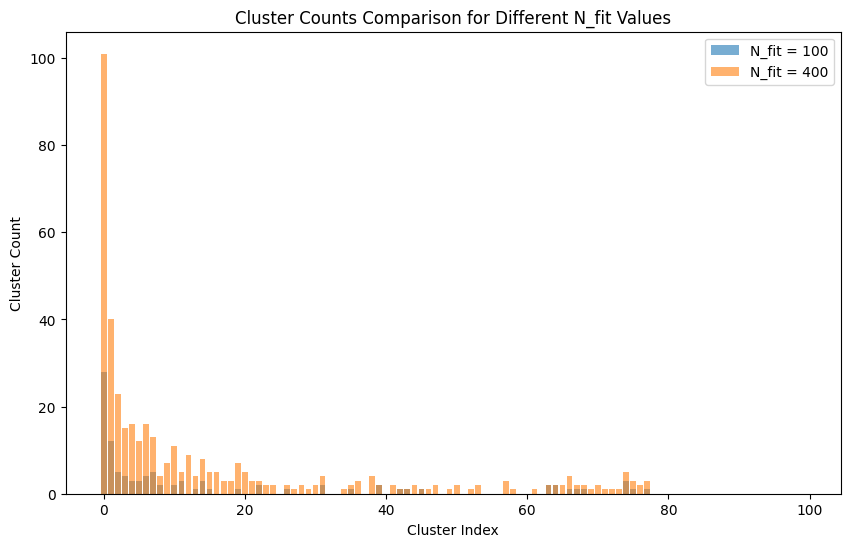

In [226]:
seed = 107
n_cluster = 100

np.random.seed(107)  # Set seed for reproducibility
N_fit_vals = [100, 400]
fpr_results = {N_fit: [] for N_fit in N_fit_vals}
tpr_results = {N_fit: [] for N_fit in N_fit_vals}
thr_results = {N_fit: [] for N_fit in N_fit_vals}
detectors = {N_fit: [] for N_fit in N_fit_vals}
for N_fit in N_fit_vals:

    detector_100_clusters = PartitionDetector(classifier, weights, means, std, n_cluster=n_cluster, alpha=0.05, seed=107)
    detector_100_clusters.fit(N=N_fit)
    detectors[N_fit].append(detector_100_clusters)
    fpr, tpr, thr, detector_hard_100_clusters = evaluate_detector(model, detector_100_clusters, weights, means, std)
    fpr_results[N_fit].append(fpr)
    tpr_results[N_fit].append(tpr)
    thr_results[N_fit].append(thr)

# Plotting the results
plt.figure(figsize=(10, 6))

# Define a color mapping for each N_fit value.
colors = {100: 'tab:blue', 400: 'tab:orange'}

for N_fit in N_fit_vals:
    detector = detectors[N_fit][0]
    # Plot the bars with a set transparency (alpha=0.6) so overlaps remain visible
    plt.bar(np.arange(n_cluster), detector.cluster_counts, 
            color=colors[N_fit], alpha=0.6, label=f'N_fit = {N_fit}')

plt.xlabel("Cluster Index")
plt.ylabel("Cluster Count")
plt.title("Cluster Counts Comparison for Different N_fit Values")
plt.legend()
plt.show()

fpr_val 0.4335898100919282
tpr_val 0.9569730137761842
thr_val 0.34398109511026903


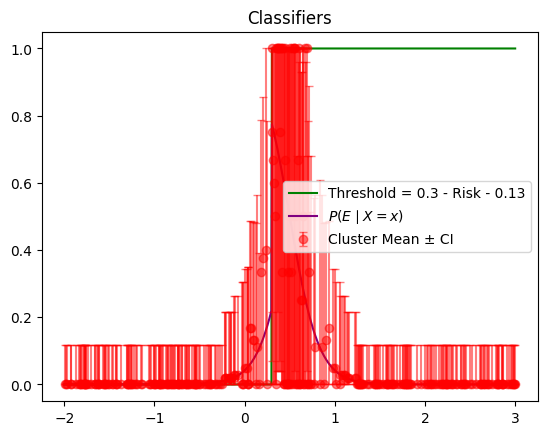

In [233]:
seed = 107
n_cluster = 100

np.random.seed(107)  # Set seed for reproducibility

detector_100_clusters = PartitionDetector(classifier, weights, means, std, n_cluster=n_cluster, alpha=0.05, seed=107)
detector_100_clusters.fit(N=500)
_, _ ,_, detector_hard_100_clusters = evaluate_detector(model, detector_100_clusters, weights, means, std)
clusters = np.array([detector_100_clusters.predict_clusters(x)  for x in xs])
cluster_means = np.array([detector_100_clusters.cluster_error_means[cluster] for cluster in clusters])
cluster_bounds = np.array([detector_100_clusters.cluster_intervals[cluster] for cluster in clusters])

yerr_lower = cluster_means - cluster_bounds[:, 0]
yerr_upper = cluster_bounds[:, 1] - cluster_means
yerr = np.vstack((yerr_lower, yerr_upper))

# Downsample r% of points in each cluster
r = 0.3  # Downsampling fraction: 30% of points from each cluster
selected_indices = []
unique_clusters = np.unique(clusters)


# For each unique cluster, randomly select r% of the indices corresponding to that cluster.
for clust in range(n_cluster):
    count = np.sum(clusters == clust)
    if count == 0:
        continue
    indices = np.where(clusters == clust)[0]
    # Ensure at least one point is selected even if r*len(indices) < 1.
    num_select = max(1, int(len(indices) * r))
    selected = np.random.choice(indices, size=num_select, replace=False)
    
    selected_indices.extend(selected)
selected_indices = np.sort(selected_indices)

# Downsample the corresponding arrays using the selected indices.
xs_down = xs[selected_indices]
cluster_means_down = cluster_means[selected_indices]
yerr_down = yerr[:, selected_indices]


xs = np.linspace(-2, 3, 1000)
threshold = 0.3
detector_ys = np.array([detector_hard_100_clusters(x) for x in xs])
mask_detector = detector_ys == 1
plt.plot(x, [classifier(x, threshold) for x in xs],
          label=f'Threshold = {threshold} - Risk - {total_proba_error(threshold):.2}', color='green')


# plt.plot(x, [bayes_hard_detector(x) for x in xs],
#           label='Bayes Detector', color='orange')
# plt.fill_between(xs, 0, 1, where=mask_detector, facecolor='red', alpha=0.3, label = "Error Detector",
#                  transform=plt.gca().get_xaxis_transform())
# plt.plot(x, [neyman_pearson_detector(x) for x in xs],
#           label="detector", color='black')
# plt.plot(x, [bayes_classifier(x) for x in xs],
#           label='Bayes classifier', color='orange')
plt.plot(x, [func_proba_error(x, classifier) for x in xs],
          label=r'$P(E \mid X=x)$', color='purple')
plt.errorbar(xs_down, cluster_means_down, yerr=yerr_down, fmt='o', color='red', capsize=3, label='Cluster Mean ± CI', alpha=0.5)
# plt.plot(x, cluster_bounds[:, 1], label='Upper Bound', color='black')
# plt.plot(x, cluster_bounds[:, 0], label='Lower Bound', color='blue')
# plt.plot(x, [density_conditionnal_error(x, weights, means, std, threshold) for x in xs],
#          label = r'$p(x \mid E)$', color='black')
# plt.plot(x, [density_conditionnal_no_error(x, weights, means, std, threshold) for x in xs],
#          label = r'$p(x \mid E^c)$', color='blue')
# plt.plot(x, [total_proba_no_error(threshold, weights, means, std) * density_conditionnal_no_error(x, weights, means, std, threshold) + total_proba_error(threshold, weights, means, std) * density_conditionnal_error(x, weights, means, std, threshold) for x in xs],
#          label = 'test', color='pink')
# plt.plot(x, mixture_pdf(x, means, std, weights), label='Mixture PDF', linestyle="--", color='black')

# plt.plot(x, mixture_cond_pdf(x, 1, means, std, weights), label='P(Y=1|X=x)', linestyle="--", linewidth=0.7, color='red')
# plt.plot(x, mixture_cond_pdf(x, 0, means, std, weights), label='P(Y=0|X=x)', linestyle="--", linewidth=0.7,color='blue')
plt.title('Classifiers')
plt.legend()

In [ ]:
fpr_val 0.4455491196219129
tpr_val 0.953576146442725
thr_val 0.1797265826560847

np.int64(11)

In [66]:
print(np.array(detector_100_clusters.cluster_counts))
print(detector_100_clusters.cluster_error_means)

[7 2 1 2 1 1 0 1 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), 0.0, np.float64(0.0), 0.0, 0.0, np.float64(0.0), 0.0, 0.0, 0.0, np.float64(1.0), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, np.float64(1.0), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, np.float64(0.0), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Soft Kmeans

# Misclassification Detetector General


In [6]:
from scipy.stats import multivariate_normal
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [7]:

# Set parameters
seed = 107
dim = 10       # Dimensionality of the data
n_classes = 7  # Number of Gaussian components (one per class)
n_samples_train = 1000  # Total number of samples to generate
n_sample_eval = 30000

# Set the seed for reproducibility
np.random.seed(seed)

# Generate parameters for the Gaussian mixture
means = np.random.rand(n_classes, dim)        # shape: (7, 10)
stds  = np.random.rand(n_classes, dim)         # shape: (7, 10) - diagonal standard deviations
weights = np.random.rand(n_classes)           
weights /= np.sum(weights)                      # Normalize to sum to 1



In [99]:
torch.diag_embed(torch.Tensor([0.2]) ** 2)

tensor([[0.0400]])

In [104]:
torch.Tensor([[0],[1]]).shape

torch.Size([2, 1])

In [102]:
print(gaussian_pdf(0, 0, 0.2))
print(multivariate_normal.pdf([0], [0],0.2**2))
print(norm.pdf(0, 0, 0.2))
mvn = MultivariateNormal(loc=torch.Tensor([0]), covariance_matrix=torch.diag_embed(torch.Tensor([0.2]) ** 2))
            # Evaluate probability density for each sample in x.
            # pdf_vals: [batch_size]
print(torch.exp(mvn.log_prob(torch.Tensor([[0],[1]]))))

1.9947114020071635
1.9947114020071635
1.9947114020071635
tensor([1.9947e+00, 7.4336e-06])


## Setup

In [9]:

def sample_from_mixture(n_samples):
    # Randomly assign each sample to one of the components according to weights
    components = np.random.choice(n_classes, size=n_samples, p=weights)
    samples = np.zeros((n_samples, dim))
    labels = np.zeros(n_samples, dtype=int)
    
    # For each sample, pick the corresponding Gaussian and generate a sample.
    for i, comp in enumerate(components):
        samples[i] = np.random.normal(loc=means[comp], scale=stds[comp])
        labels[i] = comp
        
    return samples, labels

def mixture_cond_pdf(x, y, means, vars, weights):
    return  (weights[y] * multivariate_normal.pdf(x, means[y], vars[y]) ) /  sum(w * multivariate_normal(x, m, s) for w, m, s in zip(weights, means, vars))

def bayes_classifier(x, means, vars, weights):
    # Compute the conditional probabilities for each class
    cond_probs = [mixture_cond_pdf(x, y, means, vars, weights) for y in range(len(weights))]
    # Return the class with the highest conditional probability
    return np.argmax(cond_probs)


# Create a custom PyTorch Dataset
class GaussMixtureDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = torch.tensor(samples, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return self.samples[index], self.labels[index]


# -------------------------------
# Define an Evaluation Function
# -------------------------------
def evaluate(model, dataloader, device, score_method=None):
    """
    Evaluates the model on the provided dataloader.
    
    Args:
        model: The PyTorch model to evaluate.
        dataloader: DataLoader for the test dataset.
        device: The device on which to perform computation.
        score_method (optional): A function to compute scores (e.g., softmax) from logits.
        
    Returns:
        Tuple of (predictions, targets, scores) as NumPy arrays.
    """
    model.eval()  # Switch model to evaluation mode
    test_preds = []
    test_targets = []
    test_scores = []
    
    for inputs, targets in tqdm(dataloader, total=len(dataloader), desc="Evaluating"):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        with torch.no_grad():
            # Compute logits using the model
            logits = model(inputs)
            # Compute predictions by taking the argmax over class logits.
            preds = torch.argmax(logits, dim=1)
        
        test_preds.append(preds.cpu().numpy())
        test_targets.append(targets.cpu().numpy())
    
    # Concatenate lists of arrays along the first dimension.
    test_preds = np.concatenate(test_preds, axis=0)
    test_targets = np.concatenate(test_targets, axis=0)

    return test_preds, test_targets



## Bayes Classifier

In [10]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal, Categorical
from torch.utils.data import Dataset, DataLoader
import numpy as np

# -------------------------------
# 1. Data Generation from Gaussian Mixture
# -------------------------------

class GaussianMixtureDataset(Dataset):
    def __init__(self, n_samples, means, stds, weights):
        """
        Generates samples from a Gaussian mixture model.
        
        Args:
            n_samples (int): Total number of samples to generate.
            means (torch.Tensor): Tensor of shape [n_classes, dim] representing the means.
                                  e.g., means: [n_classes, dim]
            stds (torch.Tensor): Tensor of shape [n_classes, dim] representing the standard deviations.
                                 e.g., stds: [n_classes, dim]
            weights (torch.Tensor): Tensor of shape [n_classes] representing the mixture weights.
                                    e.g., weights: [n_classes]
        """
        self.n_samples = n_samples
        self.means = means  # [n_classes, dim]
        self.stds = stds    # [n_classes, dim]
        self.weights = weights  # [n_classes]
        self.n_classes, self.dim = means.shape
        
        # Using a Categorical distribution for component selection.
        self.cat = Categorical(self.weights)  # (weights shape: [n_classes])
        
        # Sample the component indices for each sample.
        # indices: [n_samples]
        self.components = self.cat.sample((n_samples,))  # [n_samples]

        # Sample data: for each sample, use the corresponding mean and std (both shape: [dim])
        # samples: [n_samples, dim]
        self.samples = torch.normal(
            mean=self.means[self.components],   # [n_samples, dim]
            std=self.stds[self.components]        # [n_samples, dim]
        )
        # The labels are the component indices.
        # labels: [n_samples]
        self.labels = self.components

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        # Return a tuple: sample (tensor shape [dim]) and label (scalar tensor)
        return self.samples[index], self.labels[index]

# -------------------------------
# 2. Bayes Classifier as nn.Module
# -------------------------------
class BayesClassifier(nn.Module):
    def __init__(self, means, covs, weights):
        """
        A Bayes classifier implemented as an nn.Module.
        
        Args:
            means (torch.Tensor): Tensor of shape [n_classes, dim] for the component means.
            covs (torch.Tensor): Tensor of shape [n_classes, dim, dim] for the component covariance matrices.
            weights (torch.Tensor): Tensor of shape [n_classes] for the mixture weights.
        """
        super(BayesClassifier, self).__init__()
        # Register buffers so they become part of the model's state but are not trainable.
        # means: [n_classes, dim]
        self.register_buffer('means', means)
        # covs: [n_classes, dim, dim]
        self.register_buffer('covs', covs)
        # weights: [n_classes]
        self.register_buffer('weights', weights)
        self.n_classes, self.dim = means.shape

    def forward(self, x):
        """
        Computes the posterior probabilities and predicted classes.
        
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, dim].
                              e.g., x: [batch_size, dim]
        
        Returns:
            preds (torch.Tensor): Predicted class indices of shape [batch_size].
                                  e.g., preds: [batch_size]
            posterior (torch.Tensor): Posterior probabilities for each class [batch_size, n_classes].
                                      e.g., posterior: [batch_size, n_classes]
        """
        batch_size = x.shape[0]  # batch_size
        
        # Collect weighted probability densities for each class.
        probs = []
        for i in range(self.n_classes):
            # Create a multivariate normal distribution for class i using mean and covariance.
            # For each class i: mean: [dim], covariance matrix: [dim, dim]
            mvn = MultivariateNormal(loc=self.means[i], covariance_matrix=self.covs[i])
            # Evaluate probability density for each sample in x.
            # pdf_vals: [batch_size]
            pdf_vals = torch.exp(mvn.log_prob(x))  # log_prob: [batch_size], exp gives a numerical probability.
            # Multiply by the prior weight for class i: scalar * [batch_size] = [batch_size]
            probs.append(self.weights[i] * pdf_vals)
            
        # Stack the probabilities for each class along dimension 1.
        # probs: [batch_size, n_classes]
        probs = torch.stack(probs, dim=1)
        # Normalize to obtain the posterior probability for each class.
        posterior = probs / probs.sum(dim=1, keepdim=True)  # [batch_size, n_classes]
        # Predicted class: index of maximum posterior probability.
        preds = torch.argmax(posterior, dim=1)  # [batch_size]
        return preds, posterior

# -------------------------------
# 3. Risk Evaluation (Misclassification Rate)
# -------------------------------
class Evaluator:
    def __init__(self, model, dataloader, device):
        """
        Initialize the evaluator.
        
        Args:
            model (nn.Module): The Bayes classifier.
            dataloader (DataLoader): The data loader for evaluation data.
            device (torch.device): Device to run the evaluation on.
        """
        self.model = model.to(device)
        self.dataloader = dataloader
        self.device = device

    def evaluate(self):
        """
        Evaluates the model and returns the risk (classification error rate).
        
        Returns:
            risk (float): Fraction of misclassified samples.
        """
        self.model.eval()  # Set the model to evaluation mode.
        total_samples = 0
        error_count = 0
        
        with torch.no_grad():
            for x, labels in self.dataloader:
                # x: [batch_size, dim]; labels: [batch_size]
                x = x.to(self.device)
                labels = labels.to(self.device)
                preds, _ = self.model(x)  # preds: [batch_size]
                
                # Count misclassifications.
                total_samples += labels.size(0)
                error_count += (preds != labels).sum().item()
        
        risk = error_count / total_samples
        return risk

# -------------------------------
# Main Execution
# -------------------------------
def main():
    # Set random seeds for reproducibility.
    seed = 107
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Define dimensions and classes.
    dim = 10          # Dimensionality of each sample
    n_classes = 7     # Number of Gaussian components / classes
    n_samples_test = 20000  # Number of samples to generate
    batch_size_test = 64  # Batch size for DataLoader
    
    # Generate mixture parameters using torch (all tensors).
    # means: [n_classes, dim]
    means = torch.rand(n_classes, dim)  # e.g., means: [7, 10]
    # stds: [n_classes, dim]
    stds = torch.rand(n_classes, dim)   # e.g., stds: [7, 10]
    # weights: [n_classes]
    weights = torch.rand(n_classes)       # e.g., weights: [7]
    weights = weights / weights.sum()
    
    # For the Bayes classifier, we need full covariance matrices.
    # Using a diagonal covariance: cov = diag(stds_i^2) for class i.
    # covs: [n_classes, dim, dim]
    covs = torch.diag_embed(stds ** 2)    # e.g., covs: [7, 10, 10]
    
    # Create the dataset.
    dataset = GaussianMixtureDataset(n_samples_test, means, stds, weights)
    # Create DataLoader for evaluation.
    dataloader = DataLoader(dataset, batch_size=batch_size_test, shuffle=True)  # Batch: [32, dim]
    
    # Instantiate the Bayes classifier.
    bayes_model = BayesClassifier(means, covs, weights)
    
    # Define device.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Evaluate the Bayes classifier risk.
    evaluator = Evaluator(bayes_model, dataloader, device)
    risk = evaluator.evaluate()
    
    print(f"Bayes Classifier Risk (Misclassification Rate): {risk:.4f}")

if __name__ == '__main__':
    main()


Bayes Classifier Risk (Misclassification Rate): 0.0436


## Training Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import os
import json
import datetime
import pandas as pd

# -------------------------------
# 1. Data Generation: Gaussian Mixture Dataset
# -------------------------------
class GaussianMixtureDataset(Dataset):
    def __init__(self, n_samples, means, stds, weights):
        """
        Generates samples from a Gaussian mixture model.
        
        Args:
            n_samples (int): Number of samples to generate.
            means (torch.Tensor): Tensor of shape [n_classes, dim]
                                  e.g., [7, 10]
            stds (torch.Tensor): Tensor of shape [n_classes, dim]
                                 e.g., [7, 10]
            weights (torch.Tensor): Tensor of shape [n_classes]
                                    e.g., [7]
        """
        self.n_samples = n_samples
        self.means = means      # [n_classes, dim]
        self.stds = stds        # [n_classes, dim]
        self.weights = weights  # [n_classes]
        self.n_classes, self.dim = means.shape

        # Sample component indices using multinomial sampling
        # components: [n_samples]
        self.components = torch.multinomial(self.weights, n_samples, replacement=True)
        # Select means and stds for each sampled component
        # chosen_means: [n_samples, dim]
        chosen_means = self.means[self.components]
        # chosen_stds: [n_samples, dim]
        chosen_stds = self.stds[self.components]
        # Sample from the normal distribution (elementwise).
        # samples: [n_samples, dim]
        self.samples = torch.normal(mean=chosen_means, std=chosen_stds)
        # Labels are the indices of the components (classes)
        # labels: [n_samples]
        self.labels = self.components

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # Returns:
        #  sample: [dim] and label: scalar
        return self.samples[idx], self.labels[idx]

# -------------------------------
# 2. MLP Classifier for Mixture-of-Gaussians
# -------------------------------
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_size=128, num_hidden_layers=1, dropout_p=0, num_classes=7):
        """
        An MLP adapted for classifying samples drawn from a Gaussian mixture.
        
        Args:
            input_dim (int): Dimensionality of input features.
                             e.g., 10 → input: [batch_size, 10]
            hidden_size (int): Number of hidden units.
            num_hidden_layers (int): Number of additional hidden blocks.
            dropout_p (float): Dropout probability.
            num_classes (int): Number of classes, e.g., 7.
                             e.g., output: [batch_size, 7]
        """
        super(MLPClassifier, self).__init__()
        # First linear layer maps input_dim to hidden_size.
        # [batch_size, input_dim] -> [batch_size, hidden_size]
        self.layer0 = nn.Linear(input_dim, hidden_size)
        
        # Dropout applied after activation.
        self.dropout = nn.Dropout(dropout_p)
        
        # Build additional hidden layers (each with its own instance).
        if num_hidden_layers > 0:
            self.hidden_layers = nn.Sequential(
                *[ nn.Sequential(
                        nn.Linear(hidden_size, hidden_size),  # [batch_size, hidden_size]
                        nn.ReLU(),                             # [batch_size, hidden_size]
                        nn.Dropout(dropout_p)
                   ) for _ in range(num_hidden_layers)
                ]
            )
        else:
            self.hidden_layers = None
        
        # Final classifier layer produces logits for each class.
        # [batch_size, hidden_size] -> [batch_size, num_classes]
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x (torch.Tensor): Input tensor with shape [batch_size, input_dim]
                              e.g., [32, 10]
        
        Returns:
            logits (torch.Tensor): Raw output logits, [batch_size, num_classes]
            probs (torch.Tensor): Softmax probabilities, [batch_size, num_classes]
        """
        # Apply first layer and activation.
        x = torch.relu(self.layer0(x))  # [batch_size, hidden_size]
        x = self.dropout(x)             # [batch_size, hidden_size]
        if self.hidden_layers is not None:
            x = self.hidden_layers(x)   # [batch_size, hidden_size]
        logits = self.classifier(x)     # [batch_size, num_classes]
        probs = torch.softmax(logits, dim=1)  # [batch_size, num_classes]
        return logits, probs

# -------------------------------
# 3. Evaluator: Compute Accuracy
# -------------------------------
class Evaluator:
    def __init__(self, model, dataloader, device):
        """
        Evaluator for measuring model accuracy.
        
        Args:
            model (nn.Module): The trained classifier.
            dataloader (DataLoader): DataLoader for evaluation data.
            device (torch.device): Device to perform evaluation on.
        """
        self.model = model.to(device)
        self.dataloader = dataloader
        self.device = device

    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for x, labels in self.dataloader:
                # x: [batch_size, dim], labels: [batch_size]
                x = x.to(self.device)
                labels = labels.to(self.device)
                logits, _ = self.model(x)  # logits: [batch_size, num_classes]
                preds = torch.argmax(logits, dim=1)  # [batch_size]
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())
        accuracy = correct / total
        return accuracy, torch.cat(all_preds), torch.cat(all_labels)

# -------------------------------
# 4. Trainer: Training Loop and Model Optimization
# -------------------------------
class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader, device, checkpoints_dir, epochs=20, lr=1e-3):
        """
        Trainer for the MLP classifier.
        
        Args:
            model (nn.Module): The classifier to be trained.
            train_dataloader (DataLoader): Training data loader.
            val_dataloader (DataLoader): Validation data loader.
            device (torch.device): Device for computation.
            epochs (int): Number of training epochs.
            lr (float): Learning rate.
        """
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = device
        self.epochs = epochs
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss()  # Expects logits: [batch_size, num_classes] & labels: [batch_size]
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.checkpoint_dir = checkpoints_dir
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            best_accuracy = 0.0
            results = [] 
            for x, labels in tqdm(self.train_dataloader, desc=f"Epoch {epoch+1}/{self.epochs}"):
                # x: [batch_size, dim], labels: [batch_size]
                x = x.to(self.device)
                labels = labels.to(self.device)
                self.optimizer.zero_grad()
                logits, _ = self.model(x)  # logits: [batch_size, num_classes]
                loss = self.criterion(logits, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * x.size(0)
            epoch_loss = running_loss / len(self.train_dataloader.dataset)
            
            # Evaluate on validation set after each epoch.
            evaluator = Evaluator(self.model, self.val_dataloader, self.device)
            val_accuracy, _, _ = evaluator.evaluate()
            results.append({"epoch": epoch+1, "loss": epoch_loss, "val_accuracy": val_accuracy})
            print(f"Epoch {epoch+1}/{self.epochs} - Loss: {epoch_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")

            if best_accuracy < val_accuracy:
                best_accuracy = val_accuracy
                print(f"Model saved at epoch {epoch+1} with accuracy {val_accuracy:.4f}")           
                # Save checkpoint if current accuracy is best so far.
                checkpoint_path = os.path.join(self.checkpoint_dir, "best_mlp.pth")
                torch.save(self.model.state_dict(), checkpoint_path)

            print(f"Training completed. Best Test Accuracy: {best_accuracy:.4f}")
            # Save training results to a CSV file.
            results_df = pd.DataFrame(results)
            results_df.to_csv(os.path.join(self.checkpoint_dir, "training_results.csv"), index=False)


# -------------------------------
# 5. Main Pipeline: Data, Model, Training and Evaluation
# -------------------------------
def main():
    # Set random seeds for reproducibility.
    seed = 107
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Mixture-of-Gaussians parameters.
    dim = 10         # Feature dimension: each sample is [10]
    n_classes = 7    # Mixture has 7 components/classes.
    n_samples_train = 20000
    n_samples_val = 20000
    lr = 1e-3
    epochs = 10
    batch_size_train = 32
    batch_size_val = 32
    
    # Generate mixture parameters.
    # means: [7, 10]
    means = torch.rand(n_classes, dim)
    # stds: [7, 10]
    stds = torch.rand(n_classes, dim)
    # weights: [7]
    weights = torch.rand(n_classes)
    weights = weights / weights.sum()  # Normalize to sum to 1.

    config = {
        "dim": dim,
        "n_classes": n_classes,
        "n_samples_train": n_samples_train,
        "n_samples_val": n_samples_val,
        "lr": lr,
        "epochs": epochs,
        "means": means.tolist(),
        "stds": stds.tolist(),
        "weights": weights.tolist(),
        "hidden_dims": [128, 128],
        "num_hidden_layers": 2,
        "dropout_p": 0.2,
        "batch_size": 32,
        "seed": seed
    }

    # checkpoint_dir = os.path.join("../checkpoints/ce", f"mlp_1_synth")
    # os.makedirs(checkpoint_dir, exist_ok=True)
    
    # # Add the current date and time to the configuration.
    # config["trained_at"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # # Save the training configuration for reference in the checkpoint folder.
    # with open(os.path.join(checkpoint_dir, "config.json"), "w") as f:
    #     json.dump(config, f, indent=4)
    
    # Create training and validation datasets.
    train_dataset = GaussianMixtureDataset(n_samples_train, means, stds, weights)
    val_dataset = GaussianMixtureDataset(n_samples_val, means, stds, weights)
    
    # Create DataLoaders.
    train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)  # Each batch: [32, 10]
    val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)       # Each batch: [32, 10]
    
    # Instantiate the MLP classifier.
    model = MLPClassifier(input_dim=dim, hidden_size=128, num_hidden_layers=2, dropout_p=0.2, num_classes=n_classes)
    
    # Define device.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create and run the trainer.
    trainer = Trainer(model, train_loader, val_loader, device, checkpoint_dir, epochs=epochs, lr=lr)
    trainer.train()
    
    # Finally, evaluate the model.
    evaluator = Evaluator(model, val_loader, device)
    accuracy, preds, labels = evaluator.evaluate()
    print(f"Final Validation Accuracy: {accuracy:.4f}")

if __name__ == "__main__":
    main()


AttributeError: partially initialized module 'torch._dynamo' has no attribute 'decorators' (most likely due to a circular import)

In [20]:
import os
cwd = os.getcwd()
cwd

'/home/lamsade/msammut/error_detection/error-estimation/synthetic_code'

# Newman-Pearson Vrac

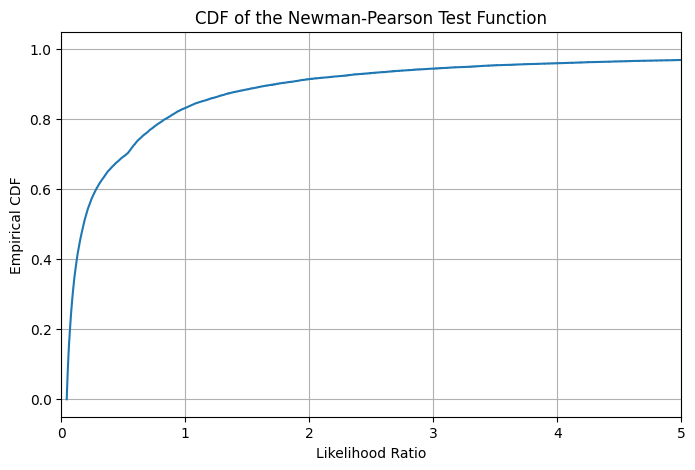

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm

# Given parameters:
means = [0.0, 1.0]
std = [0.4, 0.4]
weights = [0.5, 0.5]
threshold = 0.3

# Standard Gaussian PDF (for reference)
def gaussian_pdf(x, mean, std):
    return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)

# Total probability of error (the denominator of the conditional density)
def total_proba_error(threshold, weights=weights, means=means, std=std):
    return (weights[0] * (1 - norm.cdf(threshold, means[0], std[0])) +
            weights[1] * norm.cdf(threshold, means[1], std[1]))

def total_proba_no_error(threshold, weights=weights, means=means, std=std):
    return (weights[0] * norm.cdf(threshold, means[0], std[0]) +
            weights[1] * (1 - norm.cdf(threshold, means[1], std[1])))

# Conditional density given an error:
def density_conditionnal_error(x, weights, means, std, threshold=threshold):
    tot_proba_err = total_proba_error(threshold, weights, means, std)
    if x > threshold:
        return (weights[0] * norm.pdf(x, means[0], std[0])) / tot_proba_err
    else:
        return (weights[1] * norm.pdf(x, means[1], std[1])) / tot_proba_err

# Conditional density given no error:
def density_conditionnal_no_error(x, weights, means, std, threshold=threshold):
    tot_proba_noerr = total_proba_no_error(threshold, weights, means, std)
    if x > threshold:
        return (weights[1] * norm.pdf(x, means[1], std[1])) / tot_proba_noerr
    else:
        return (weights[0] * norm.pdf(x, means[0], std[0])) / tot_proba_noerr

# --- Sampling from density_conditionnal_error ---
# The error density is piecewise defined:
# For x > threshold: component from Gaussian(mean=means[0], std=std[0])
# For x <= threshold: component from Gaussian(mean=means[1], std=std[1])
# Their (unnormalized) weights:
p1 = weights[0] * (1 - norm.cdf(threshold, means[0], std[0]))  # x > threshold
p2 = weights[1] * norm.cdf(threshold, means[1], std[1])         # x <= threshold
tot = p1 + p2
# Normalized weights:
prob_component1 = p1 / tot  # probability that x > threshold (using component 0)
prob_component2 = p2 / tot  # probability that x <= threshold (using component 1)

# For truncated sampling, we use scipy.stats.truncnorm.
# For component 1: sample from N(means[0], std[0]) truncated to (threshold, ∞)
a1 = (threshold - means[0]) / std[0]
b1 = np.inf  # No upper truncation
# For component 2: sample from N(means[1], std[1]) truncated to (-∞, threshold)
a2 = -np.inf
b2 = (threshold - means[1]) / std[1]

# Sample N points from the error density:
N = 30000
x_samples = np.zeros(N)

for i in range(N):
    if np.random.rand() < prob_component1:
        # Draw from component 1: truncated normal for x > threshold.
        x_samples[i] = truncnorm.rvs(a1, b1, loc=means[0], scale=std[0])
    else:
        # Draw from component 2: truncated normal for x <= threshold.
        x_samples[i] = truncnorm.rvs(a2, b2, loc=means[1], scale=std[1])

# --- Compute Newman-Pearson test function ---
# For each sampled x, compute the likelihood ratio:
#    LR(x) = density_conditionnal_no_error(x) / density_conditionnal_error(x)
LR_samples = np.array([
    density_conditionnal_no_error(x, weights, means, std, threshold) /
    density_conditionnal_error(x, weights, means, std, threshold)
    for x in x_samples
])

# --- Compute Empirical CDF ---
# Sort the likelihood ratio values:
LR_sorted = np.sort(LR_samples)
# The empirical CDF values correspond to the ranks:
cdf_values = np.arange(1, N + 1) / N

# --- Plot the empirical CDF ---
plt.figure(figsize=(8, 5))
plt.step(LR_sorted, cdf_values, where='post')
plt.xlabel("Likelihood Ratio")
plt.xlim(0, 5)
plt.ylabel("Empirical CDF")
plt.title("CDF of the Newman-Pearson Test Function")
plt.grid(True)
plt.show()


In [108]:
# Define the quantile level (for example, 0.95 for the 95th percentile)
alpha = 0.99

# N is the total number of samples; for instance, N = len(LR_sorted)
N = len(LR_sorted)

# The index of the alpha quantile
index = int(np.ceil(alpha * N)) - 1  # Subtract 1 for zero-based indexing

# The alpha quantile of the likelihood ratio
quantile_alpha = LR_sorted[index]

print("Estimated quantile at level", alpha, ":", quantile_alpha)

Estimated quantile at level 0.99 : 12.553192319923532


In [109]:
def neyman_pearson_detector(x):
    ratio = density_conditionnal_no_error(x, weights, means, std, threshold=0.3) / density_conditionnal_error(x, weights, means, std, threshold=0.3)
    if ratio > quantile_alpha:
        return 0
    else:
        return 1